# Compute autocorrelation of rank-order per-individual

In [1]:
import random
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PlotConfig,
    save_factory,
    COLORMAPS,
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap, keyfilter, pluck, drop, curry
from aging.behavior.bio_age_model import (
    fit_model,
    masked_xval,
)
from scipy.spatial.distance import pdist, squareform
from itertools import product

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "fig4-longv2-bambi-autocorrelations", tight_layout=False)

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_

### new approach for modeling these data

1. get sample of each mouse across age bins (ages will not be the same across individuals)
2. re-define mouse ages within each age bin so that they are all the same
3. when computing autocorrelations, interpolate age for mice without samples within a certain bin
4. 

## Test auto-correlating mice within same chron. age group

In [4]:
def fill_mode(row):
    return row.fillna(row.mode().iloc[0])


def fill_mean(row):
    return row.fillna(row.mean())


def fill_median(row):
    return row.fillna(row.median())

In [5]:
def load_male_long_df():
    keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_counts_matrix_v00.parquet"
    )
    size_df = pd.read_parquet(
        '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_mouse_area_df_v00.parquet'
    )

    df = df[keep_syllables]
    df = df.join(size_df[['quant_0.5']])

    idx_names = df.index.names
    age = df.index.get_level_values('age')

    # bins = pd.cut(age, 92, labels=False)
    bins = pd.cut(age, 60, labels=False)

    sample = df.reset_index().groupby(['mouse', bins], observed=True).first()
    sample.index.rename("bin", level=1, inplace=True)
    sample_map = sample.groupby('bin')['age'].mean()
    sample = sample.reset_index().set_index(idx_names)

    age_cut = pd.cut(sample.index.get_level_values('age'), 11)

    sample['quant_0.5'] = zscore(sample.groupby(age_cut, observed=True)['quant_0.5'].transform(demean))

    sample = sample.reset_index(level='age')
    sample['age'] = sample['bin'].map(sample_map)

    return sample.set_index(["bin", "age"], append=True)


def load_female_long_df():
    keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_counts_matrix_v00.parquet"
    )
    size_df = pd.read_parquet(
        '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_mouse_area_df_v00.parquet'
    )

    df = df[keep_syllables]
    df = df.join(size_df[['quant_0.5']])

    idx_names = df.index.names
    age = df.index.get_level_values('age')

    # bins = pd.cut(age, 92, labels=False)
    bins = pd.cut(age, 60, labels=False)

    sample = df.reset_index().groupby(['mouse', bins], observed=True).first()
    sample.index.rename("bin", level=1, inplace=True)
    sample_map = sample.groupby('bin')['age'].mean()
    sample = sample.reset_index().set_index(idx_names)

    age_cut = pd.cut(sample.index.get_level_values('age'), 11)

    sample['quant_0.5'] = zscore(sample.groupby(age_cut, observed=True)['quant_0.5'].transform(demean))

    sample = sample.reset_index(level='age')
    sample['age'] = sample['bin'].map(sample_map)

    return sample.set_index(["bin", "age"], append=True)

In [6]:
m_df = load_male_long_df()
m_size_col = m_df['quant_0.5']
m_df = m_df.drop(columns=['quant_0.5'])

f_df = load_female_long_df()
f_size_col = f_df['quant_0.5']
f_df = f_df.drop(columns=['quant_0.5'])

df = pd.concat([m_df, f_df])
size_col = pd.concat([m_size_col, f_size_col])
sort_idx = np.argsort(df.to_numpy().sum(0))[::-1]

label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
sex_id = label_encoder.fit_transform(np.hstack([np.zeros(len(df) - len(f_df)), np.ones(len(f_df))])[:, None]).T

mouse_ids = label_encoder.fit_transform(df.index.get_level_values("mouse").to_numpy()[:, None]).T

mouse_cat = label_encoder.categories_[0]

syllable_counts_jax = jnp.array(df.astype('float32'))
age = jnp.array(df.index.get_level_values('age'))
assert size_col.isna().sum() == 0, "issue with NaNs in size data"

In [7]:
df['sex'] = np.argmax(sex_id, axis=0)
df = df.set_index('sex', append=True)

In [8]:
animals_per_sex = df.reset_index().groupby('sex')['mouse'].nunique().tolist()

In [9]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": size_col.to_numpy(),  # models > 1
    "sex": sex_id,
    "mice": mouse_ids,
}

age_sd = 0.045

hypparams = {
    "log_age": True,
    "min_age": 1,
    "max_age": 130,
    "age_sd": age_sd,
    "n_age_samples": 750,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 5,
    "n_sex_splines": 5,
    "scale": 175,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "n_animals_per_sex": animals_per_sex,
    "n_sexes": len(sex_id),
    "lr": 0.2,
    "n_opt_iter": 900,
}

In [11]:
value = ['age_flicker', 'rank_diff', 'ac_tau', 'mono', 'mae']

In [12]:
keep_keys = ['heldout_ll', 'heldout_r2_total', 'heldout_r2_total_v3', 'true_ages', 'bio_ages', 'log_bio_ages']
keeper = curry(keyfilter)(lambda k: k in keep_keys)

In [13]:
def estimate_tau(acf, threshold=0.368):
    # Find the index of the first value below the threshold
    acf = acf.loc[0:].copy()
    mask = acf < threshold
    tau_index = np.argmax(mask)
    if mask.sum() > 0:
        return tau_index
    return len(acf)

### Optimize Age SD

In [ ]:
ac_time = np.arange(-20, 21)

outs = []
predictions = []

for age_sd, n_splines, scale in tqdm(list(product(np.logspace(-3, 0, 5), range(4, 8), np.arange(100, 401, 50)))):
    hypparams["age_sd"] = float(age_sd)
    hypparams["n_splines"] = int(n_splines)
    hypparams["scale"] = float(scale)

    try:
        tmp = masked_xval(features, hypparams, 6, n_repeats=3, disable_tqdm=True)
        for k, v in tmp.items():
            v["log_bio_ages"] = v["init_components"].age_normalizer(v["bio_ages"])
        tmp = valmap(keeper, tmp)
        for k, v in tmp.items():
            outs.append(
                {
                    "repeat": k,
                    "age_sd": age_sd,
                    "n_splines": n_splines,
                    "scale": scale,
                    "total_resid": np.abs(v["true_ages"] - v["bio_ages"]).mean(),
                    **v,
                }
            )
            tmp_df = pd.DataFrame(
                dict(
                    bio=v["bio_ages"],
                    log_bio=v["log_bio_ages"],
                    chron=v["true_ages"],
                    repeat=k,
                    age_sd=age_sd,
                    n_splines=n_splines,
                    scale=scale,
                )
            )
            tmp_df["mouse_id"] = df.index.get_level_values("mouse")
            tmp_df["bin"] = df.index.get_level_values("bin")

            predictions.append(tmp_df)
    except ValueError:
        print(f"Error {age_sd:0.2f}; {n_splines}")
        pass

outs_df = pd.DataFrame(outs)
predictions = pd.concat(predictions)

  0%|          | 0/140 [00:00<?, ?it/s]

182178
Error 0.00; 7
182178
Error 0.00; 7
182178
Error 0.00; 7
182178
Error 0.00; 7
182178
Error 0.00; 7
182178
Error 0.00; 7
182178
Error 0.00; 7
182178
Error 0.01; 7
182178
Error 0.01; 7
182178
Error 0.01; 7
182178
Error 0.01; 7
182178
Error 0.01; 7
182178
Error 0.01; 7
182178
Error 0.01; 7


In [18]:
predictions.to_parquet('/n/scratch/users/w/wg41/2024-06-05-long-v2-bambi-param-scan.parquet')

In [ ]:
tmp_out = []
for (age_sd, n_splines, scale, r), p in tqdm(predictions.groupby(["age_sd", "n_splines", "scale", "repeat"])):
    monotonicity = (
        (
            p.groupby("chron")["bio"]
            .std()
            .rolling(3, center=True, min_periods=1)
            .mean()
            .diff(2)
            / 2
        )
        > 0
    ).mean()
    median_bio_mae = (
        p.groupby("chron")["bio"]
        .median()
        .reset_index()
        .diff(axis=1)
        .drop(columns=["chron"])
        .abs()
        .mean()["bio"]
    )

    # compute difference in rank
    bio_age_df = p.pivot_table(index='bin', columns='mouse_id', values='bio')
    mtx = bio_age_df.interpolate().rank(axis=1)
    # mtx = bio_age_df.apply(fill_median, axis=1).rank(axis=1)
    avg_rank_diff = (mtx.diff(periods=3) / 3).abs().mean().mean()
    ac_dict = {}
    for m in mtx.columns:
        ac_dict[m] = [mtx[m].autocorr(x) for x in ac_time]
    ac_df = pd.DataFrame(ac_dict, index=ac_time)
    taus = ac_df.apply(estimate_tau).rename("tau")
    age_flicker = (p.groupby('mouse_id')['bio'].diff(periods=2) / 2).abs().mean()

    tmp_out.append(
        dict(
            mono=monotonicity,
            mae=median_bio_mae,
            ac_tau=taus.mean(),
            med_ac_tau=taus.median(),
            repeat=r,
            age_sd=age_sd,
            n_splines=n_splines,
            scale=scale,
            rank_diff=avg_rank_diff,
            age_flicker=age_flicker,
        )
    )
tmp_out = pd.DataFrame(tmp_out)

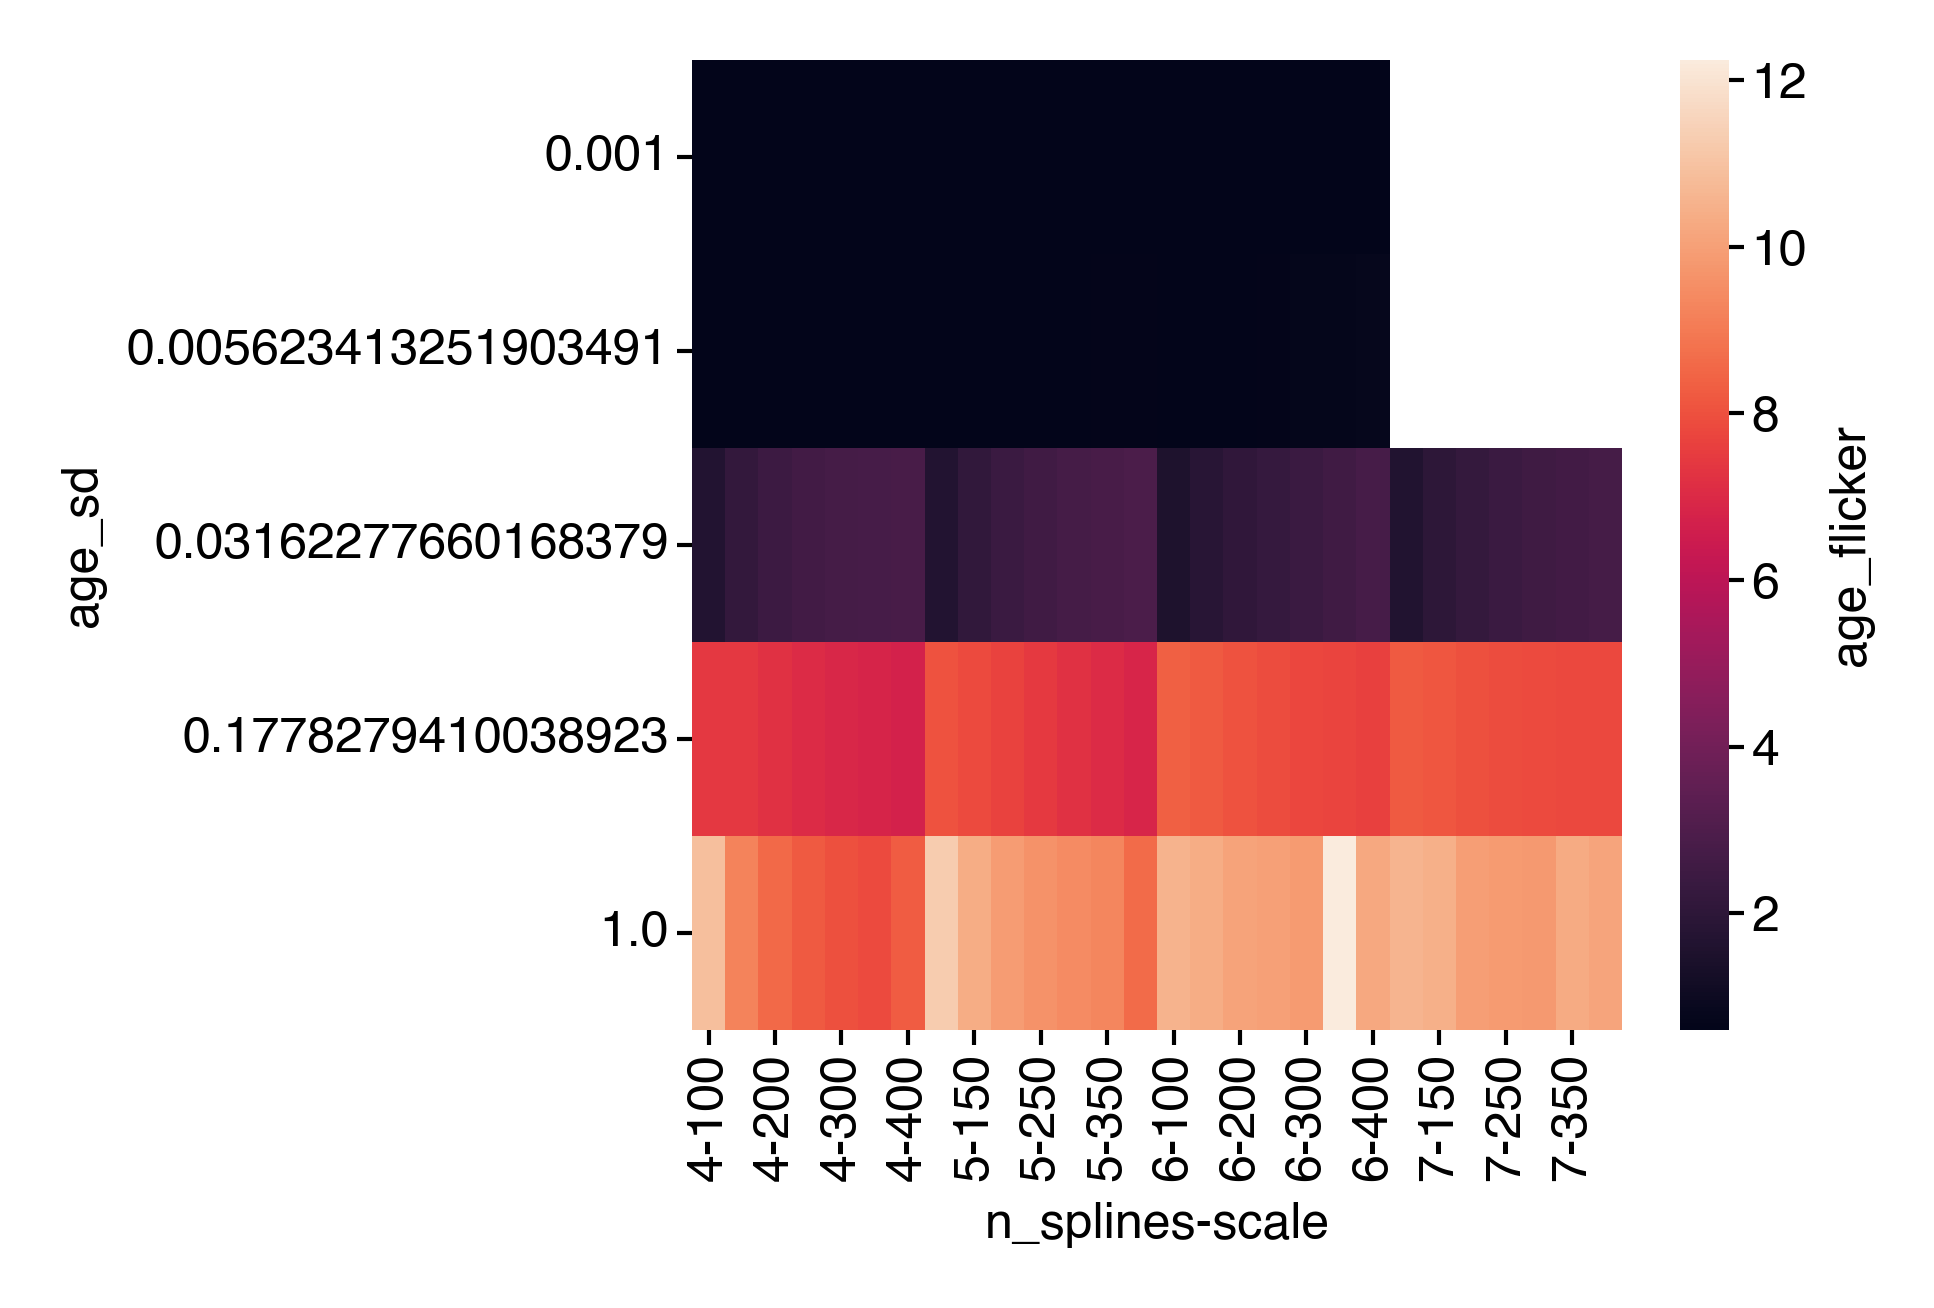

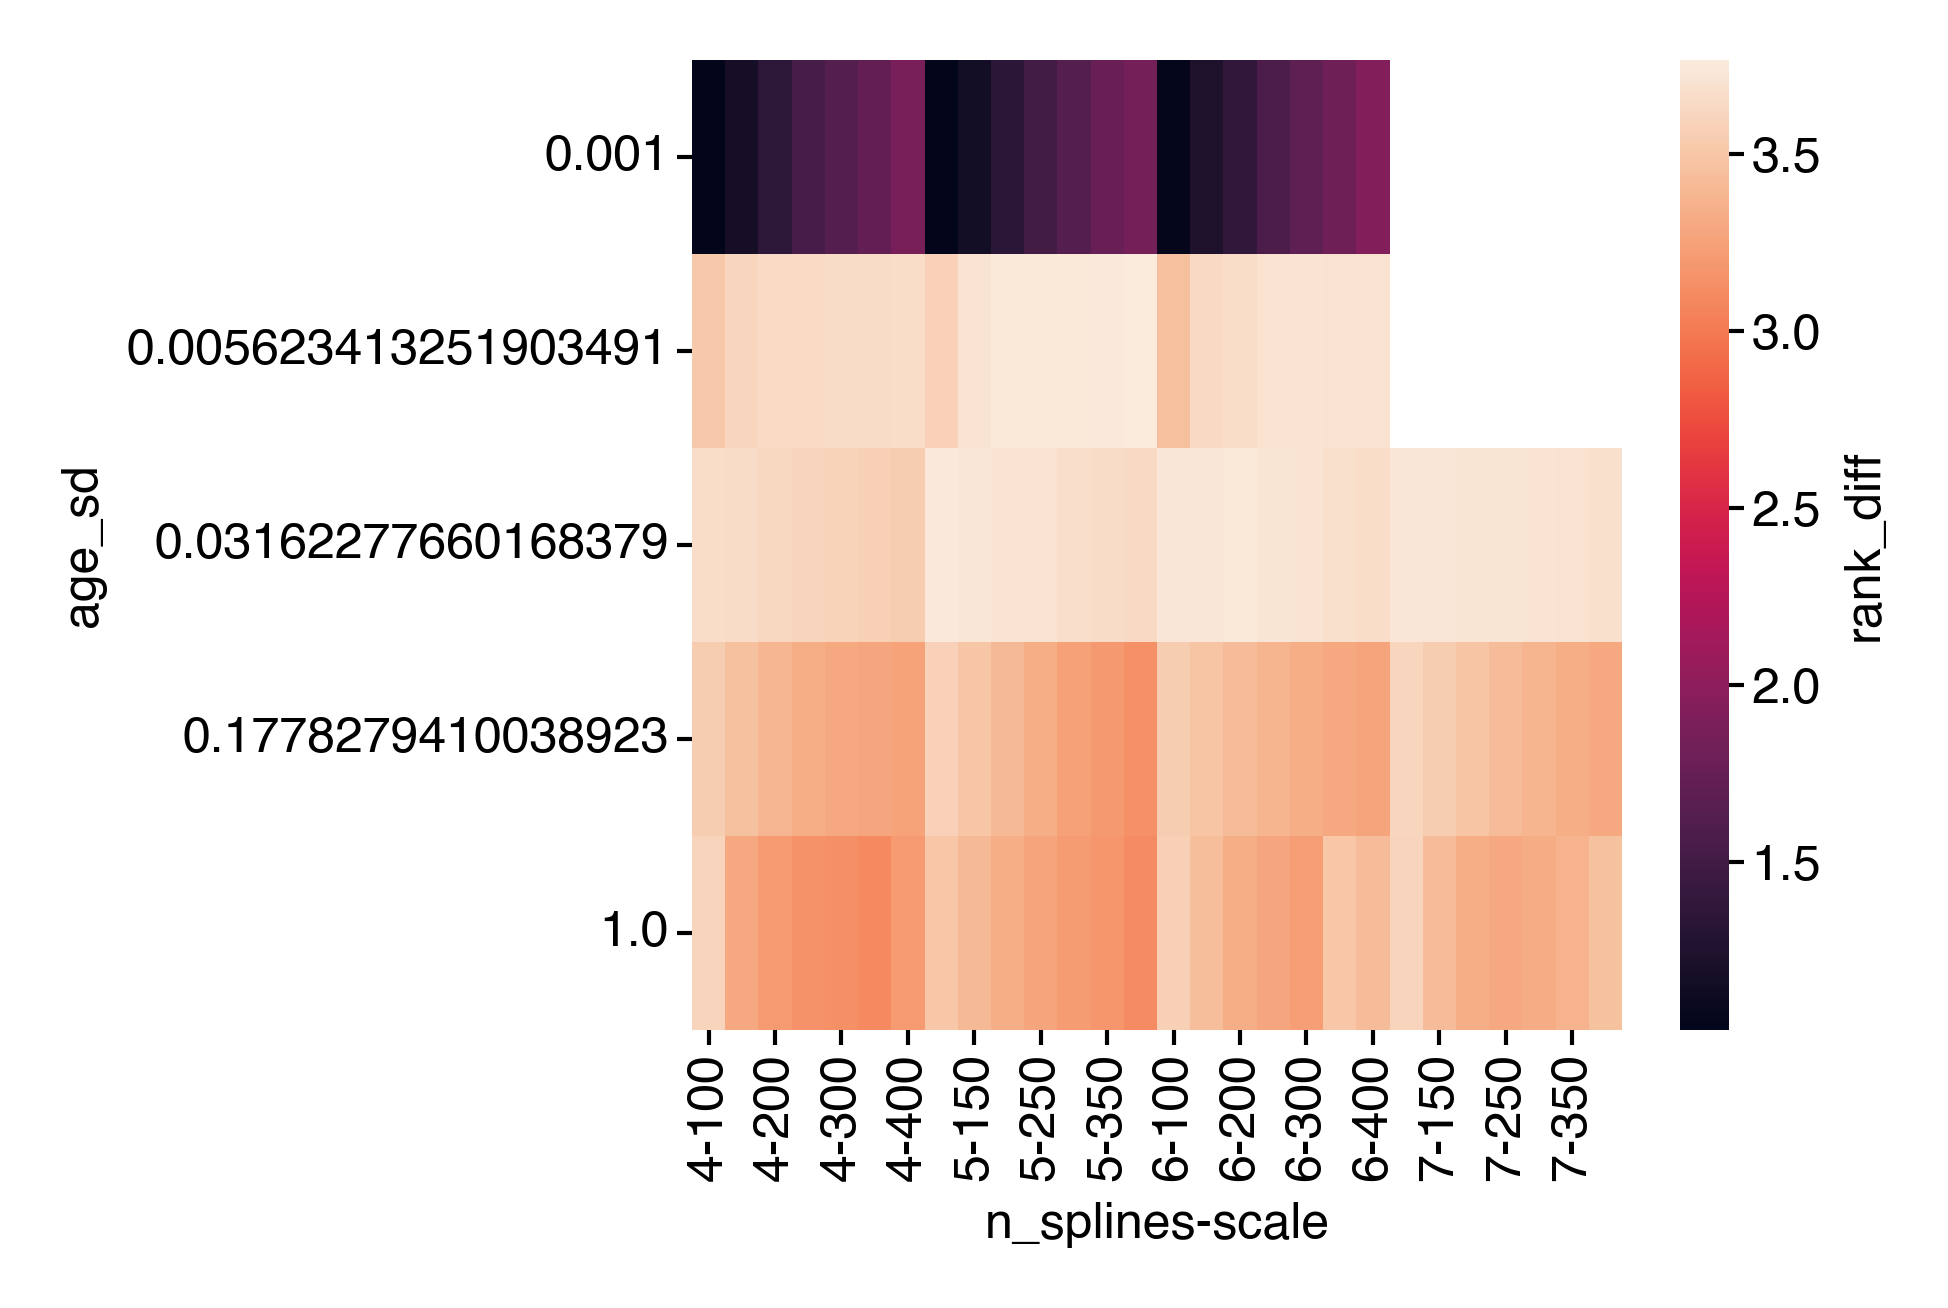

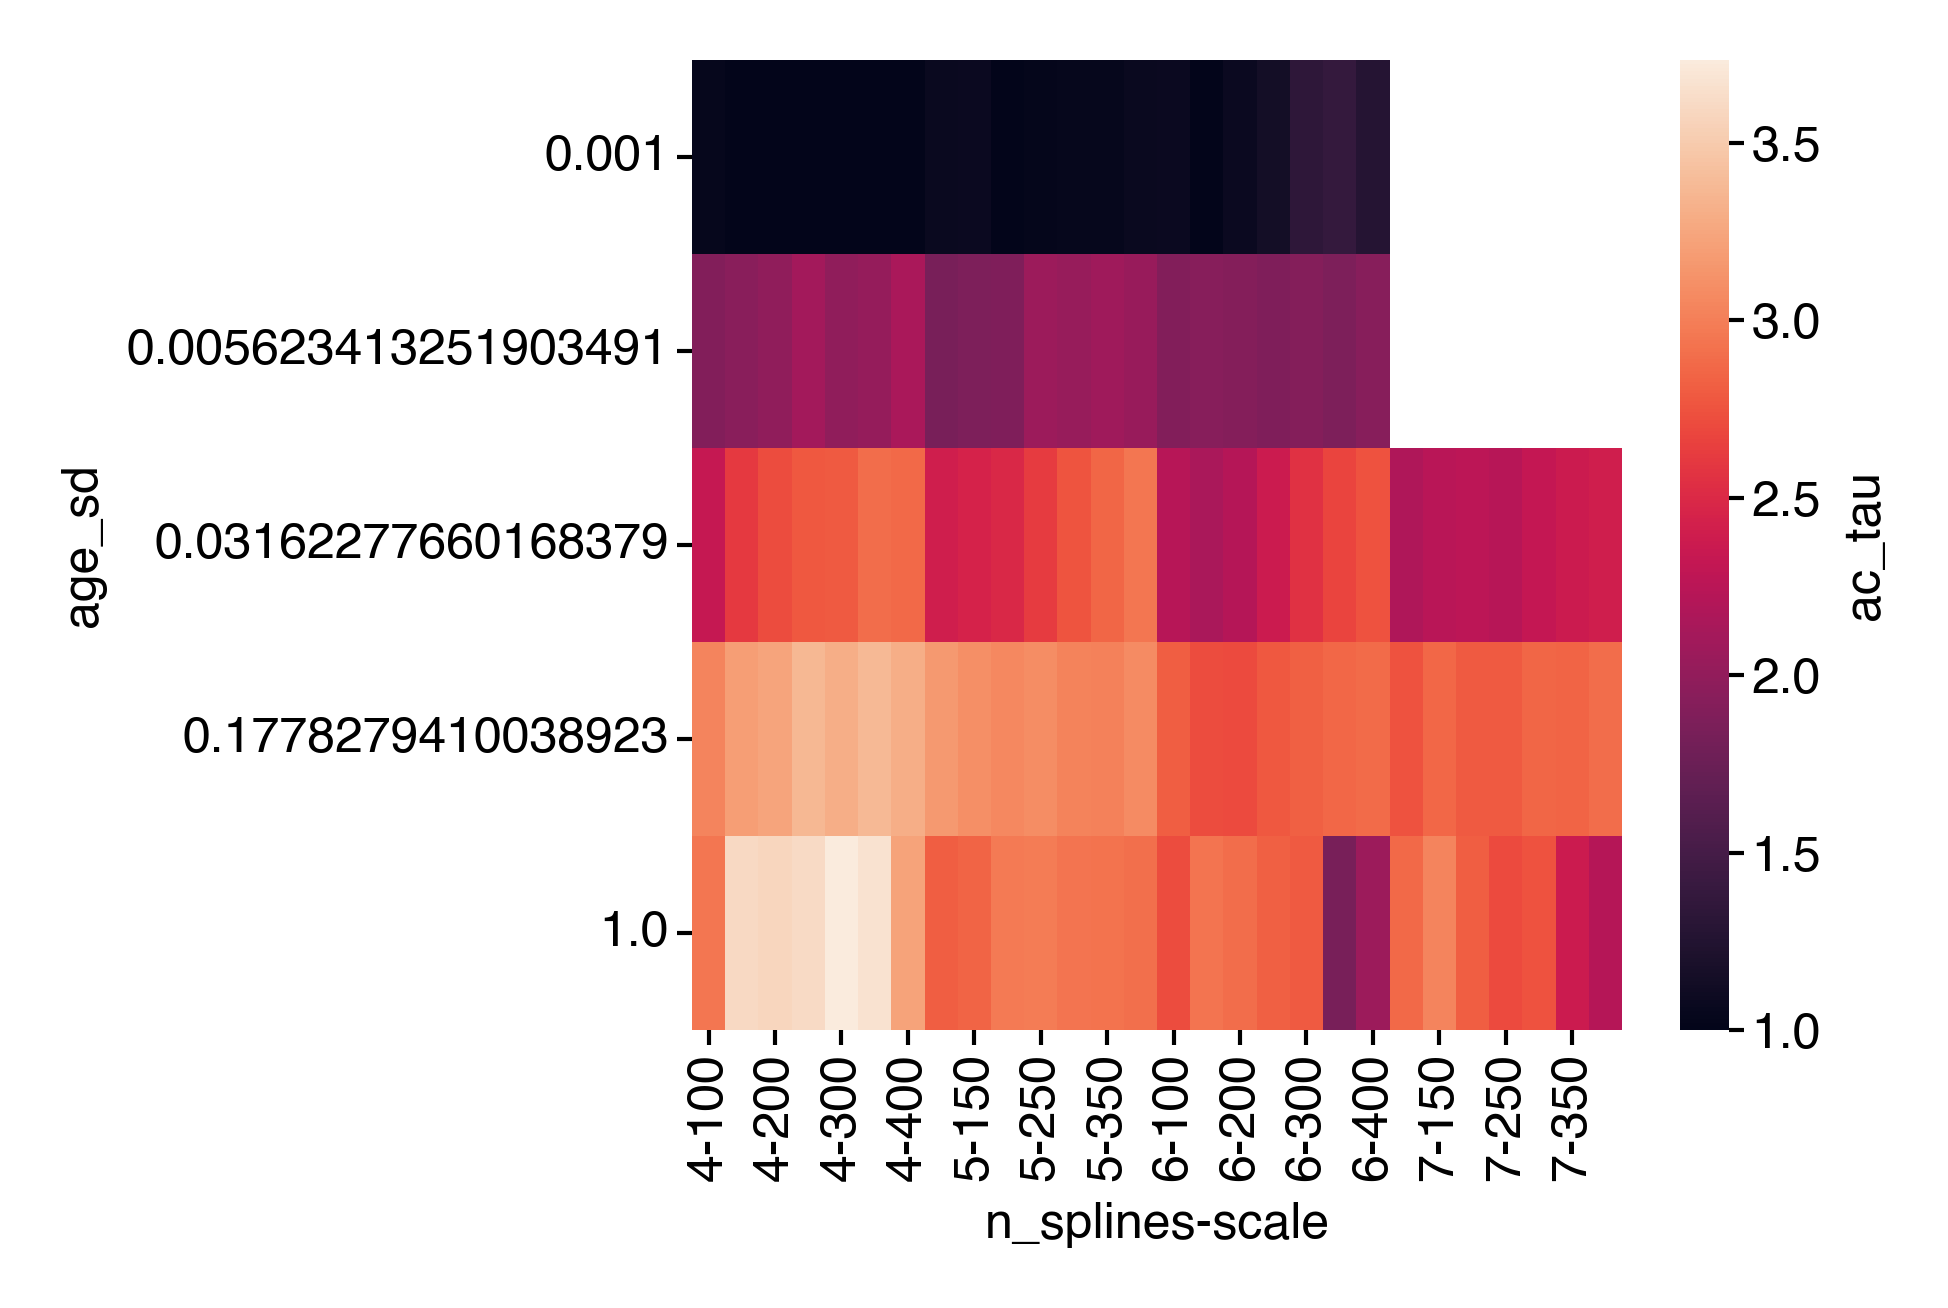

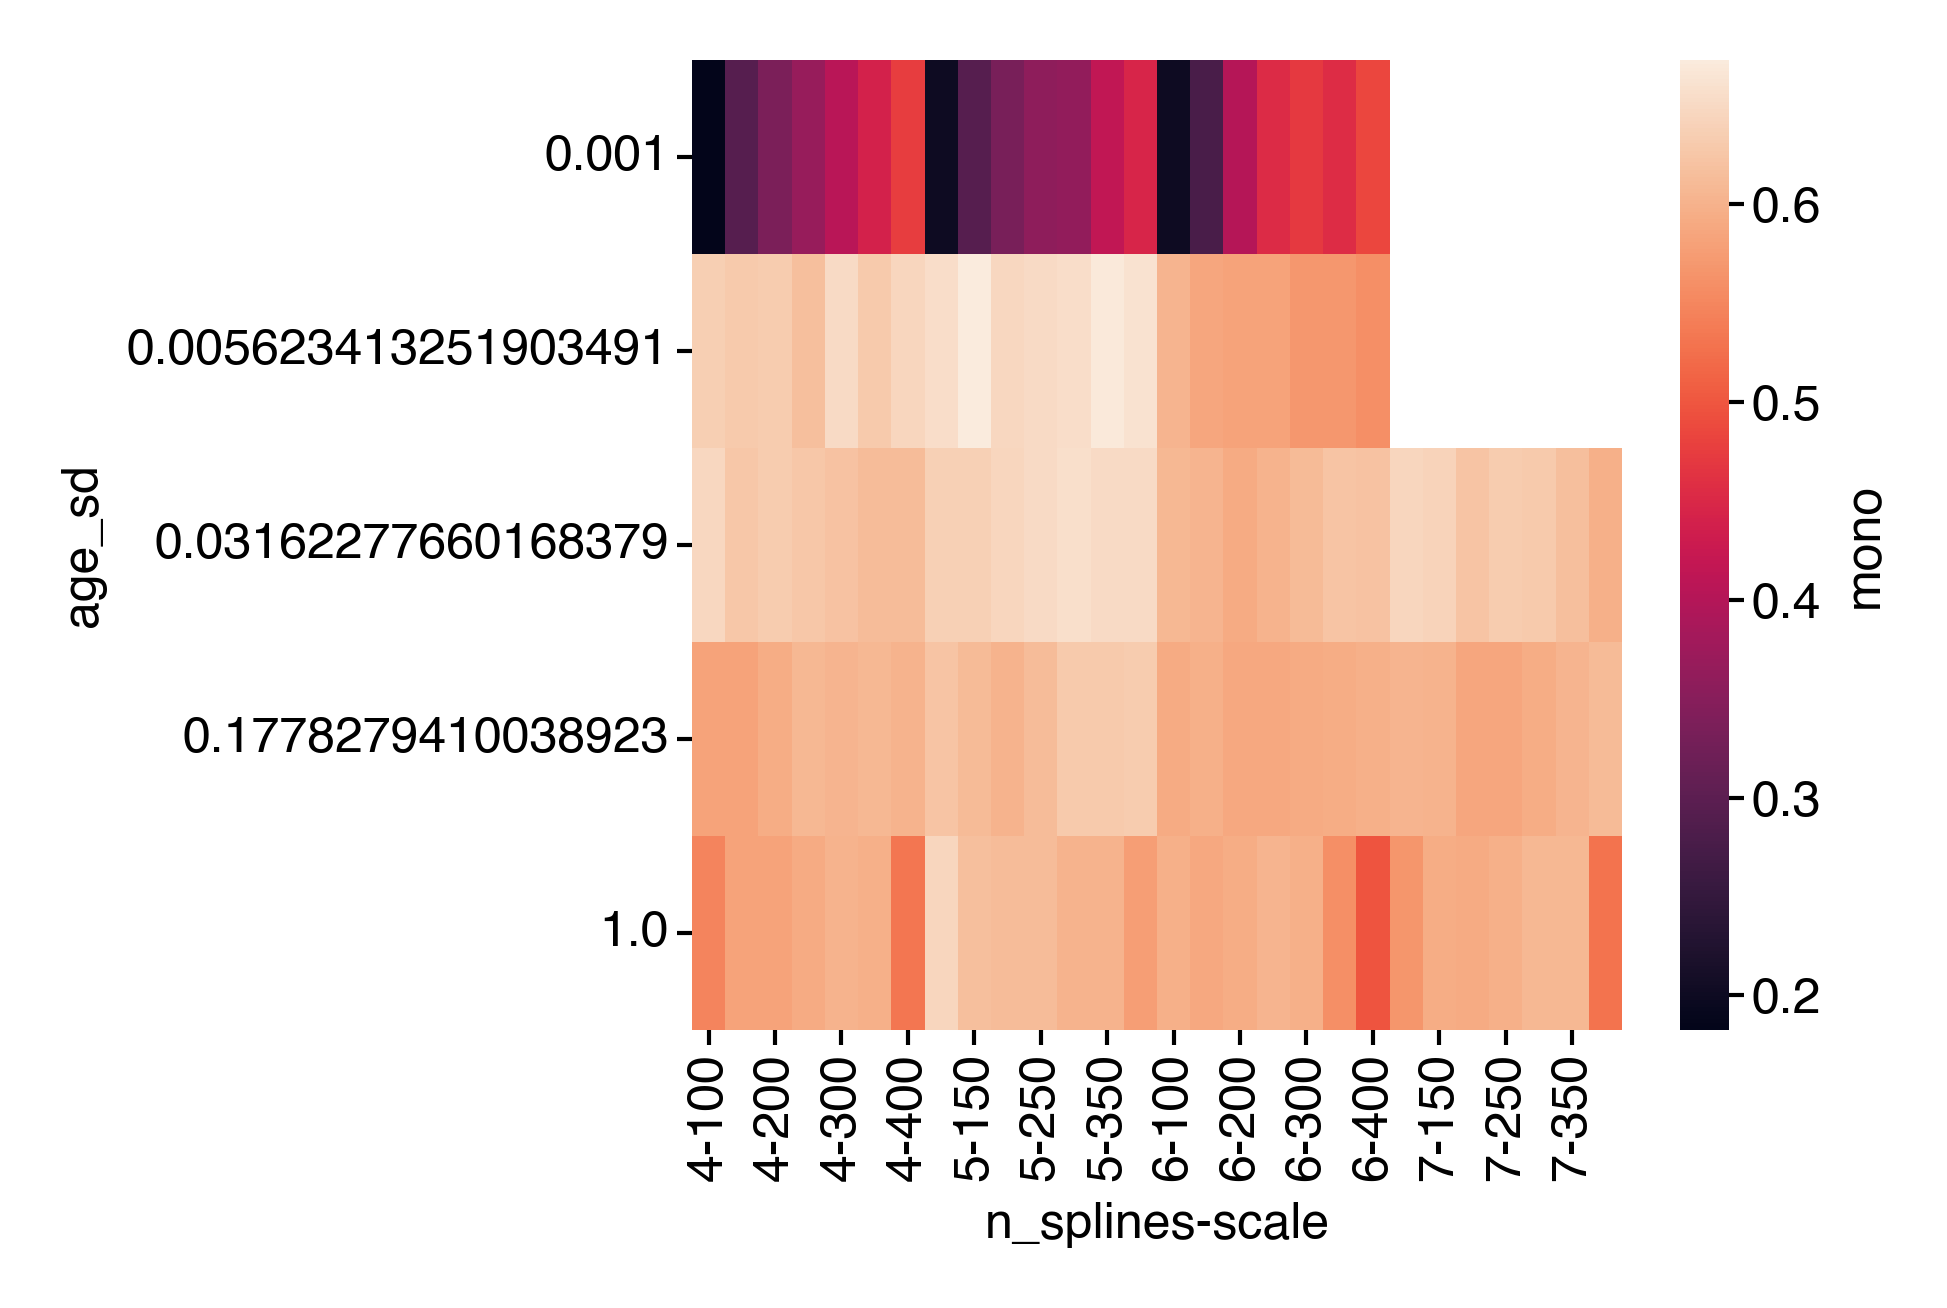

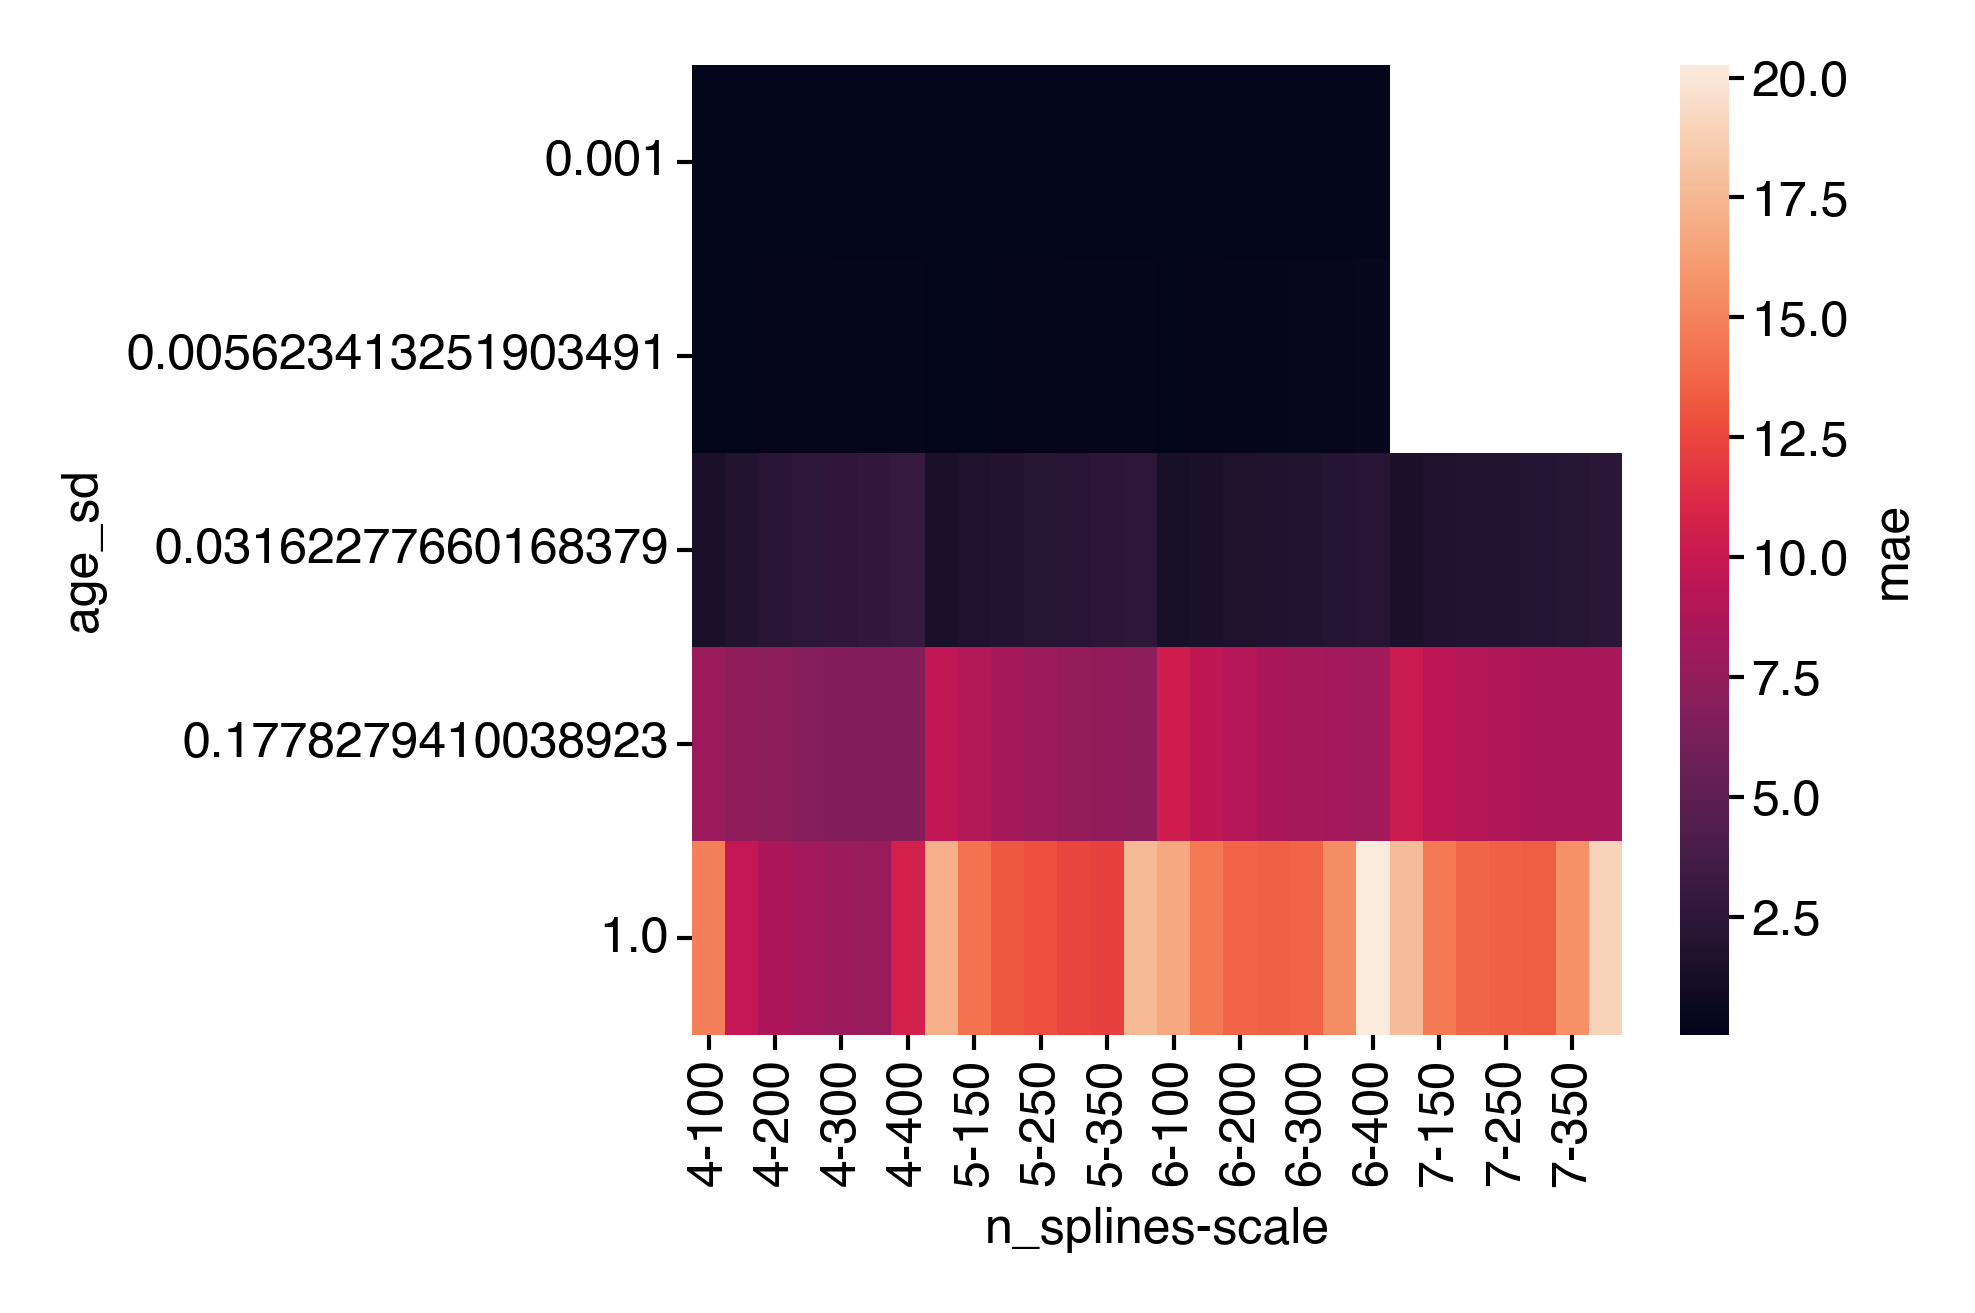

In [24]:
for v in value:
    x = tmp_out.pivot_table(index='age_sd', columns=['n_splines', 'scale'], values=v)
    fig = figure(2.5, 2.1)
    sns.heatmap(x, cbar_kws=dict(label=v))

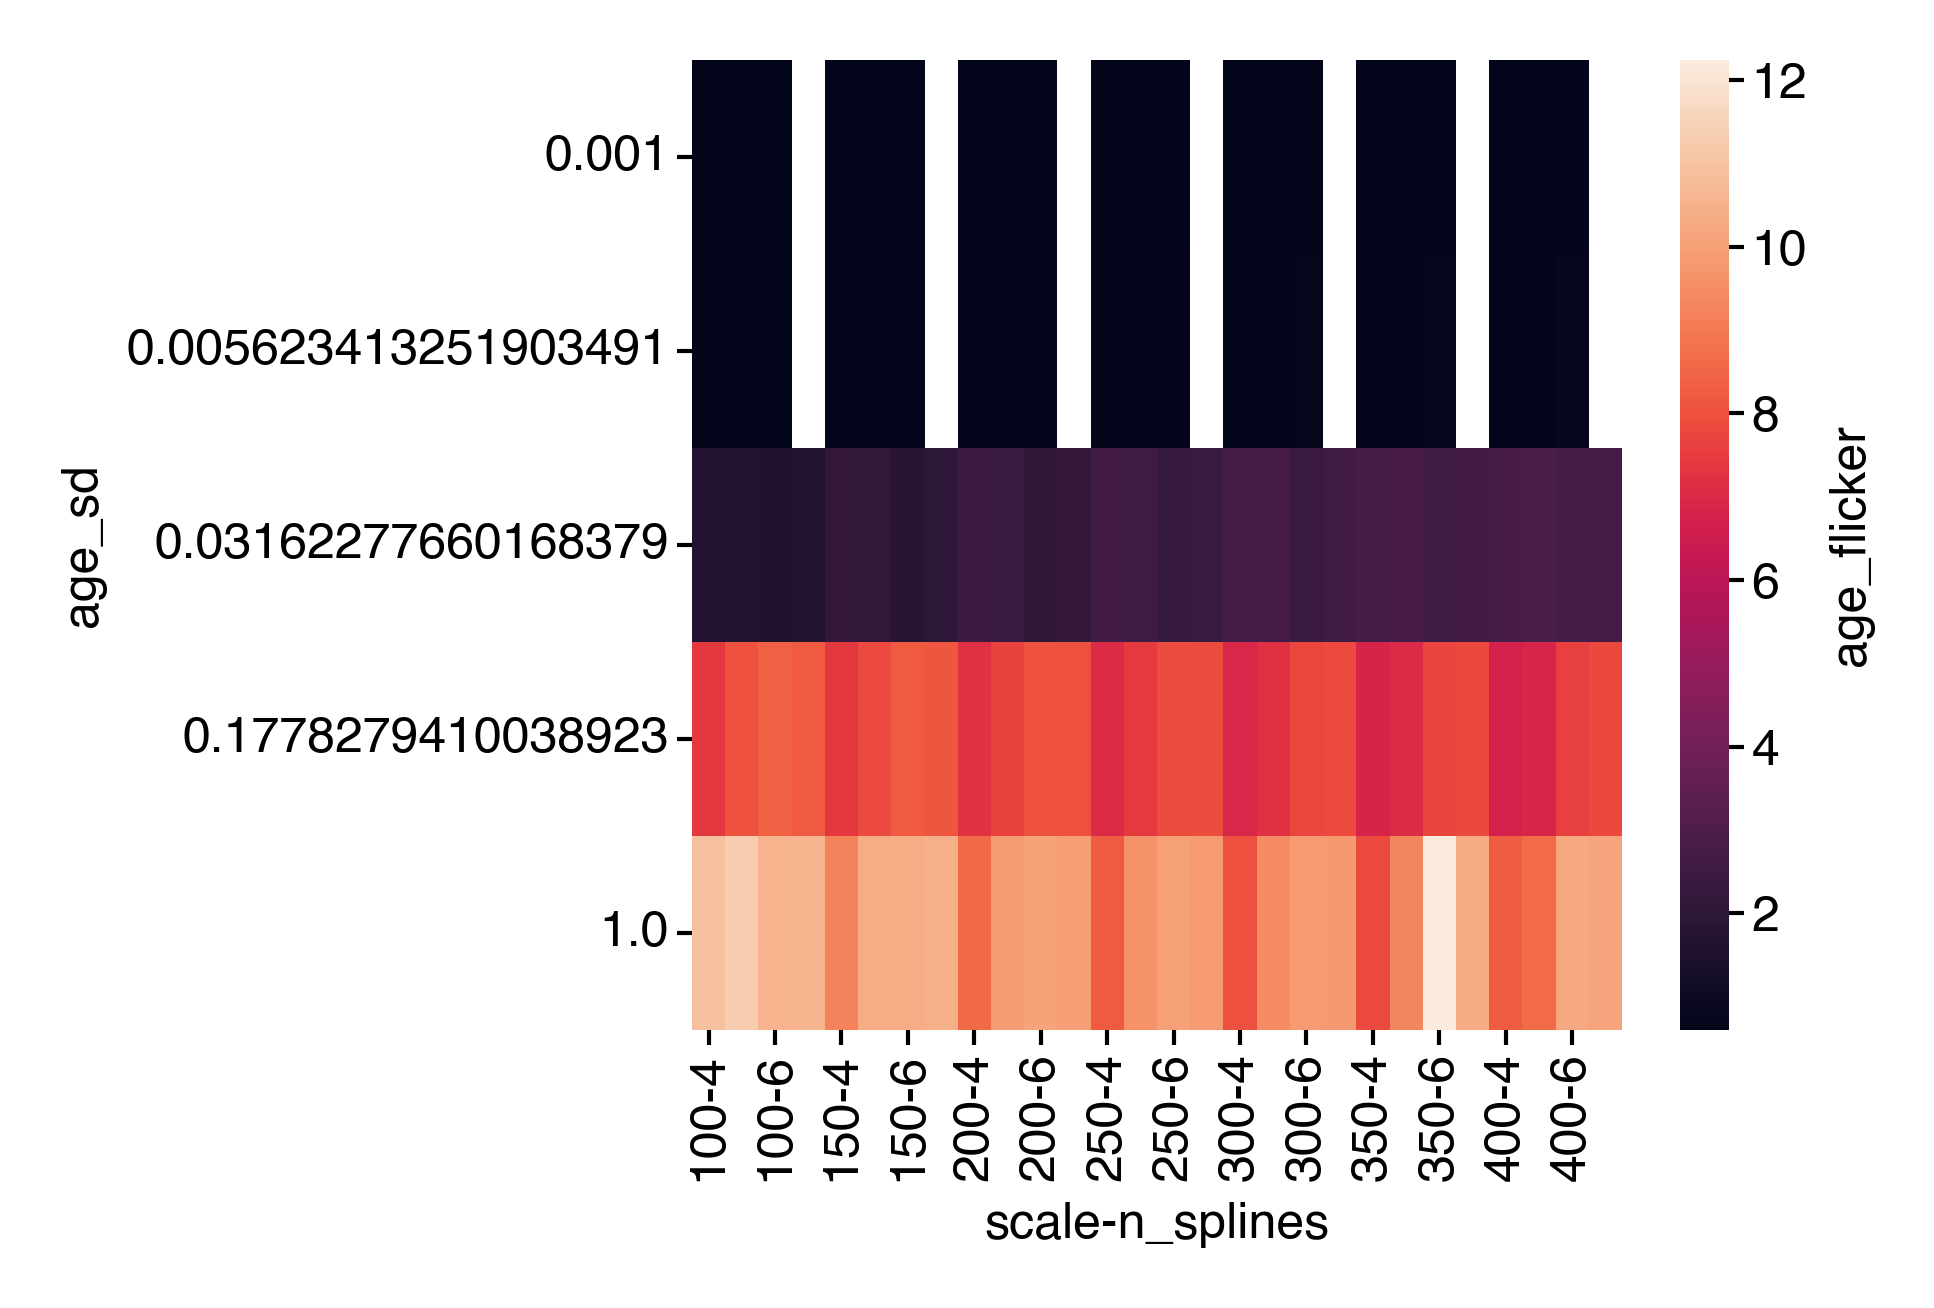

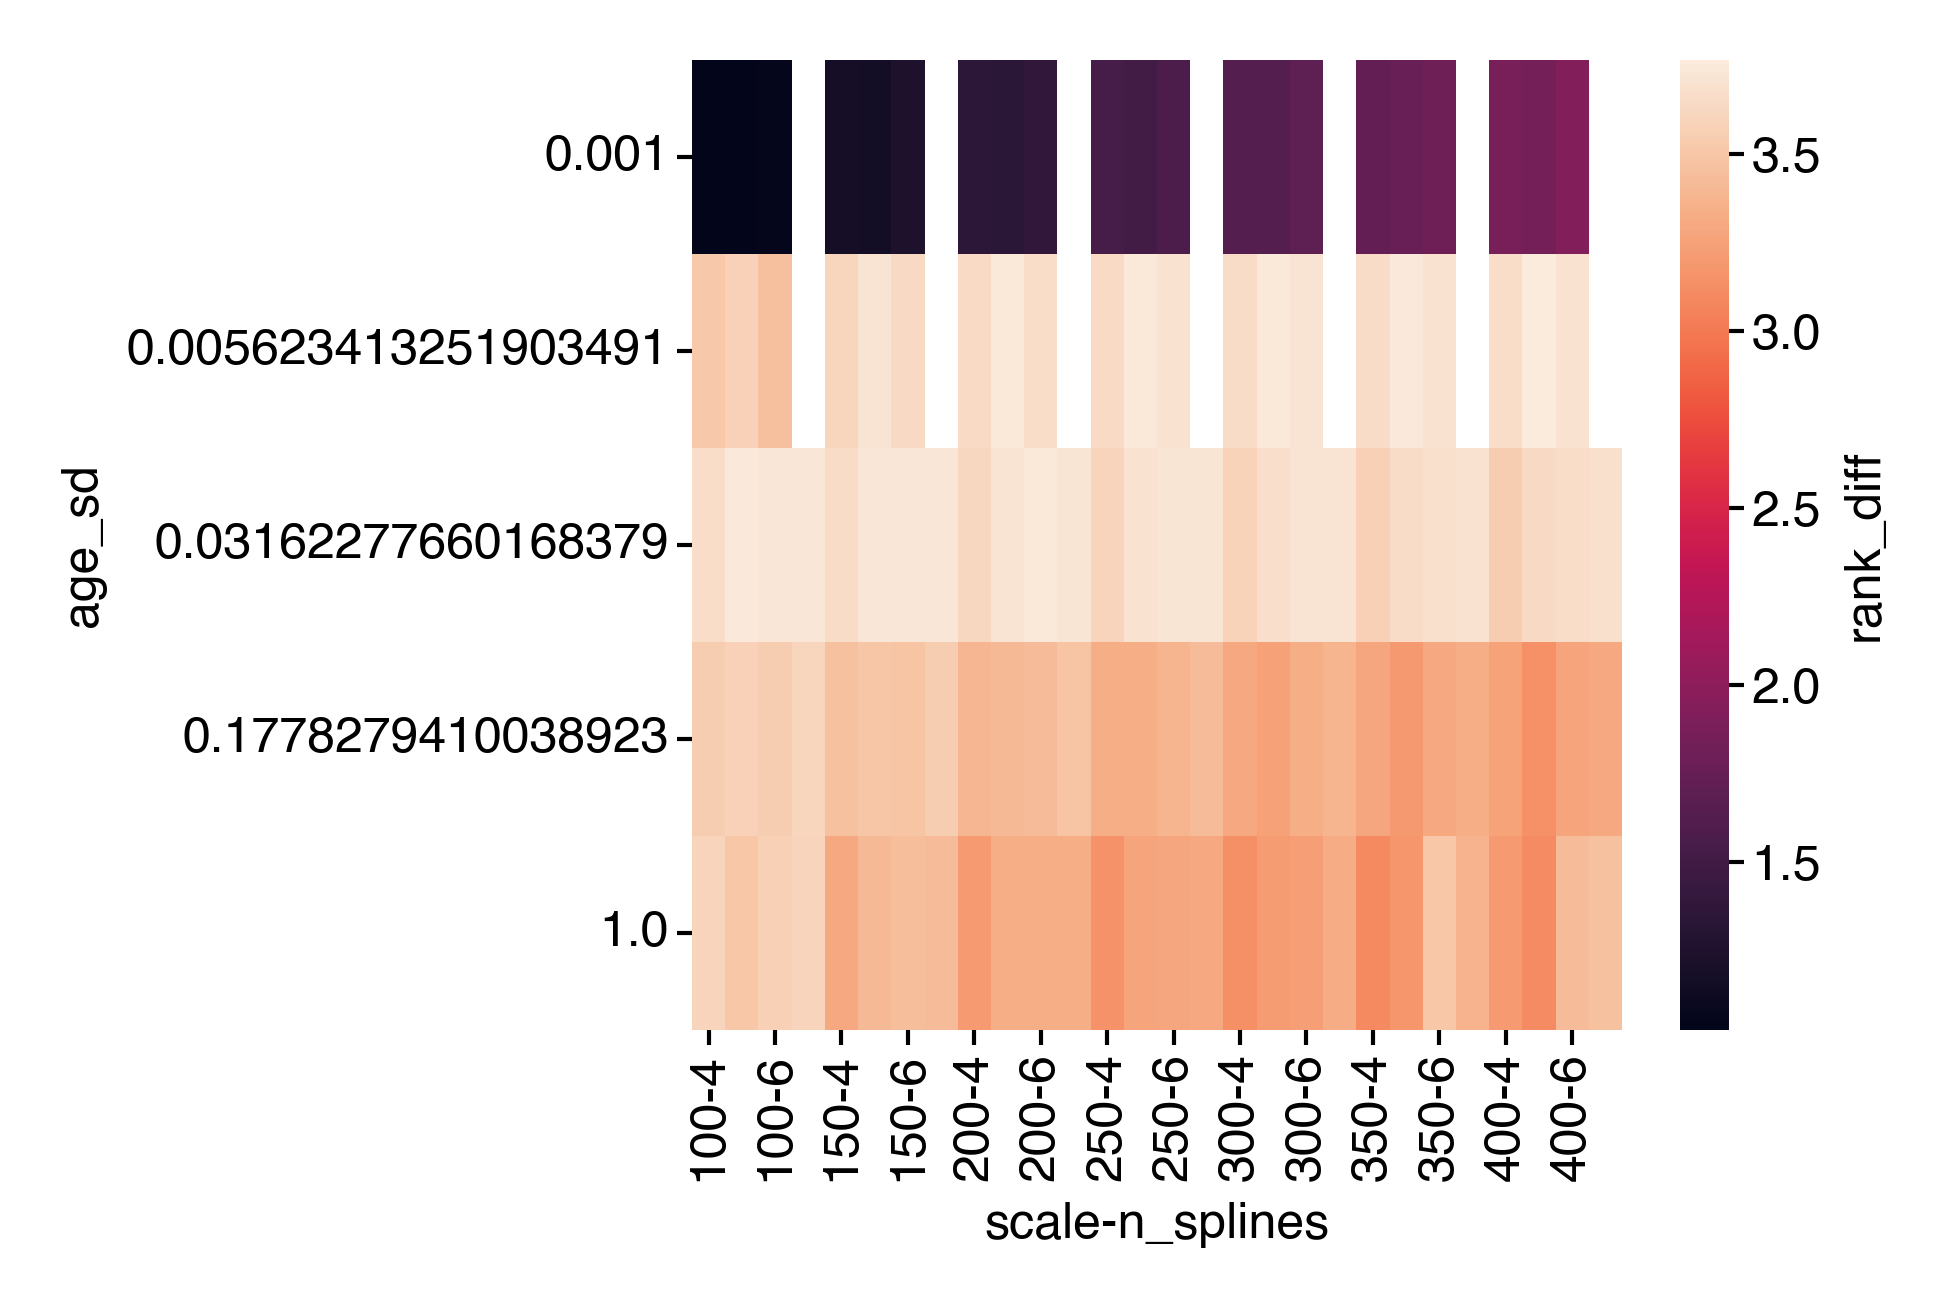

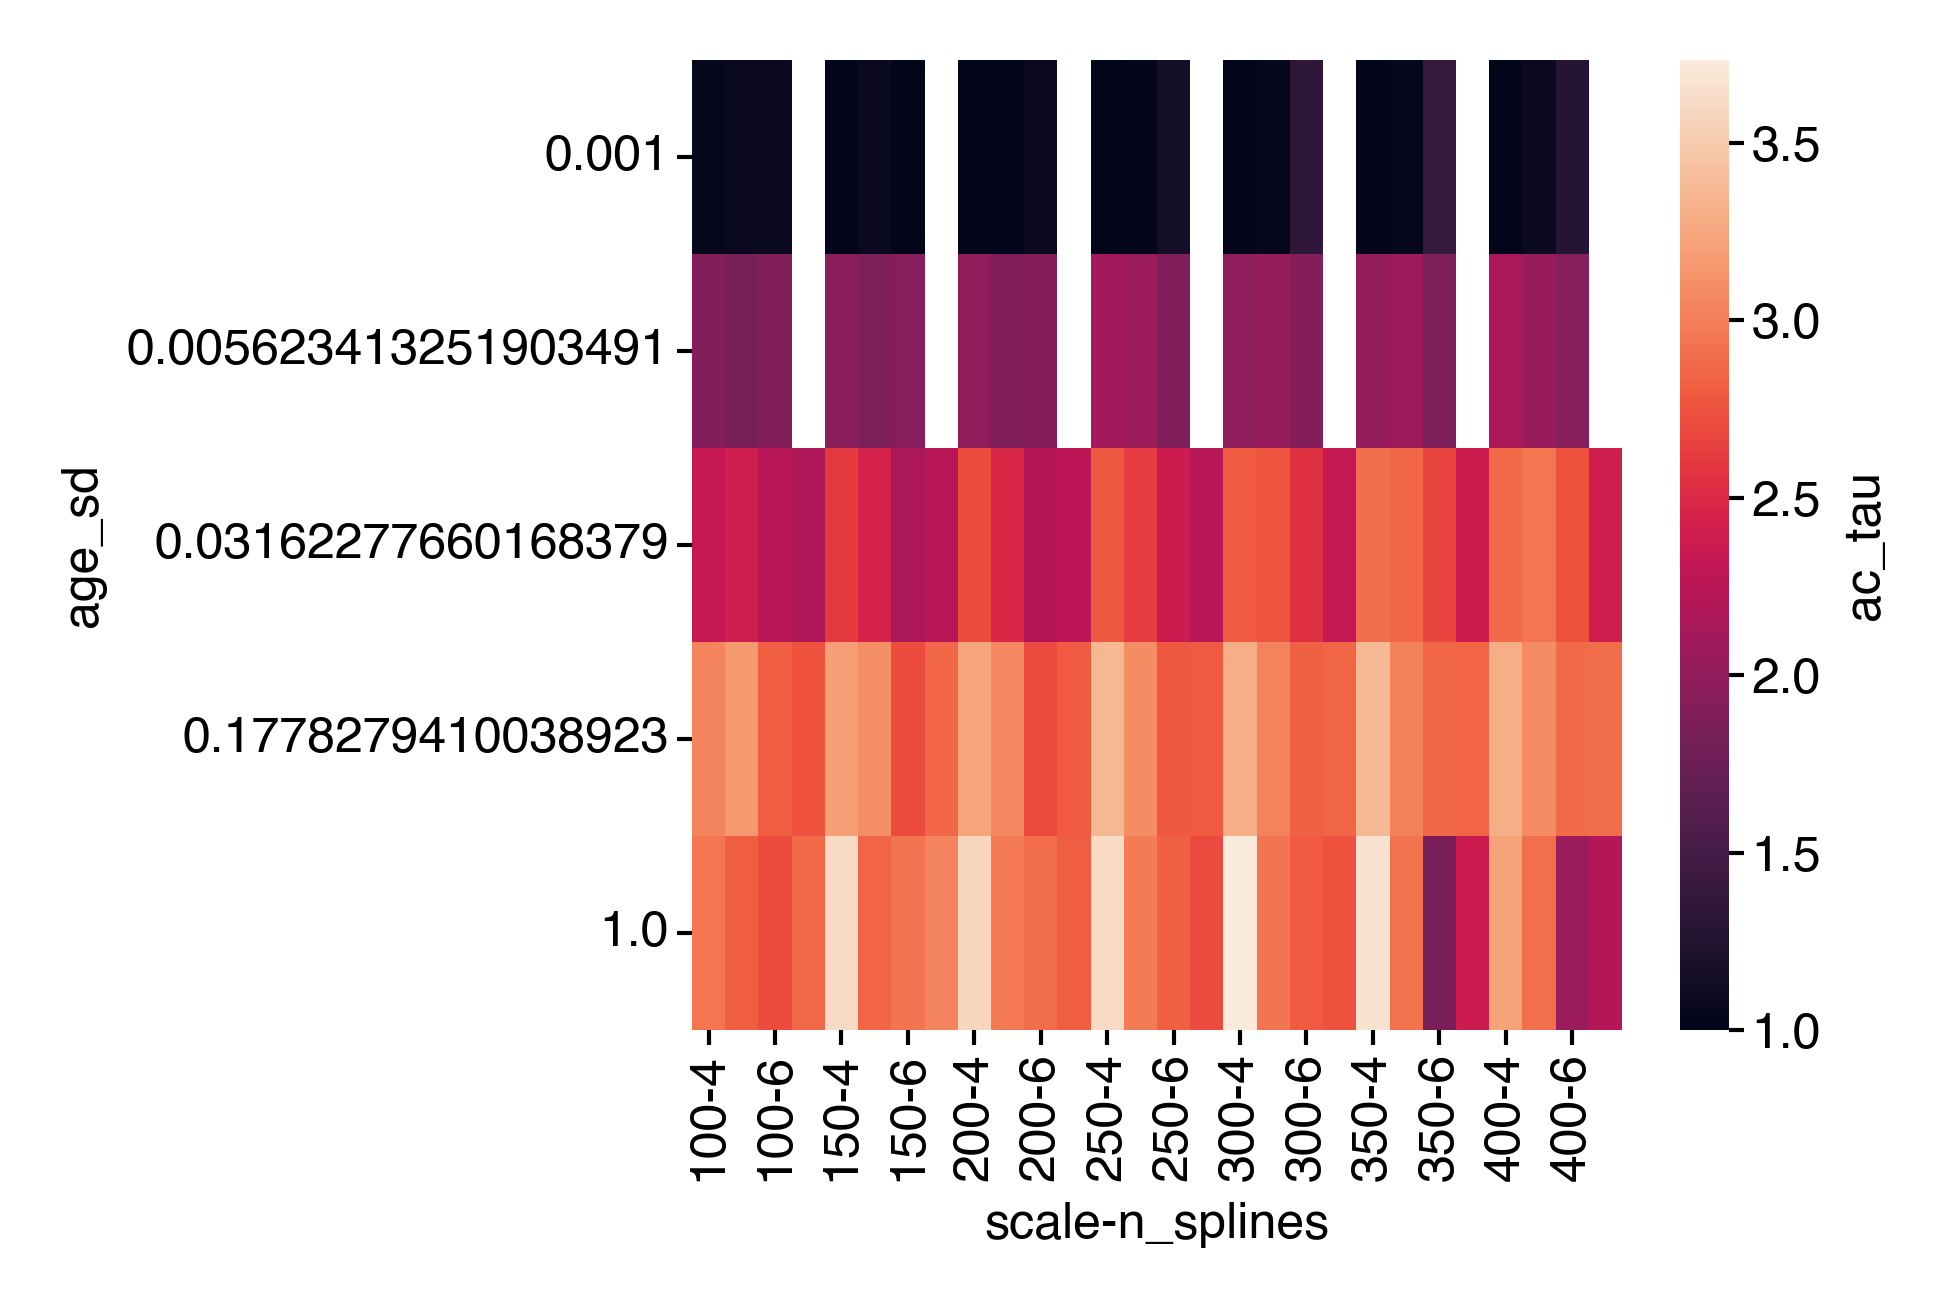

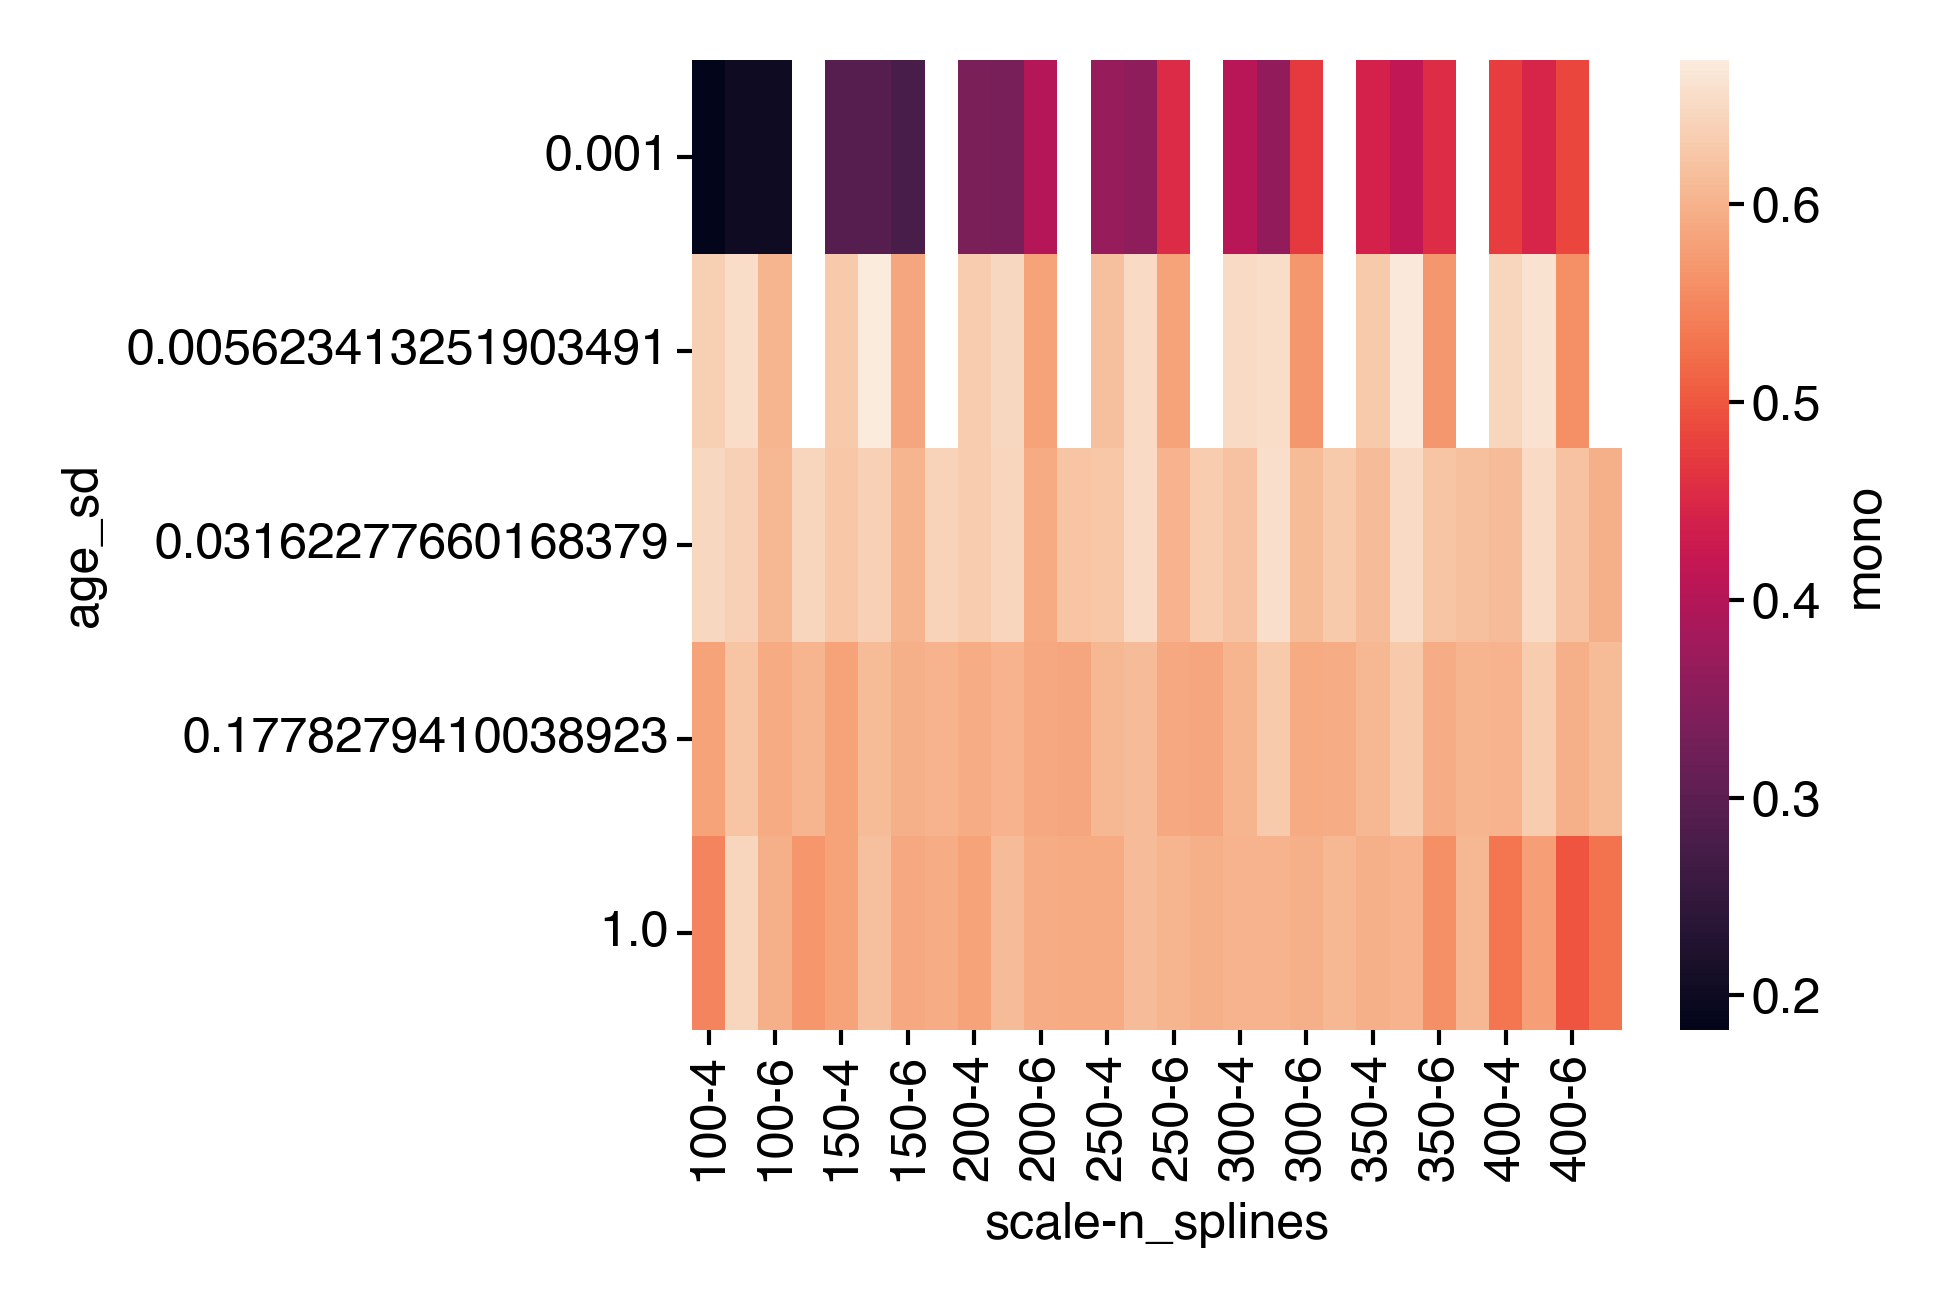

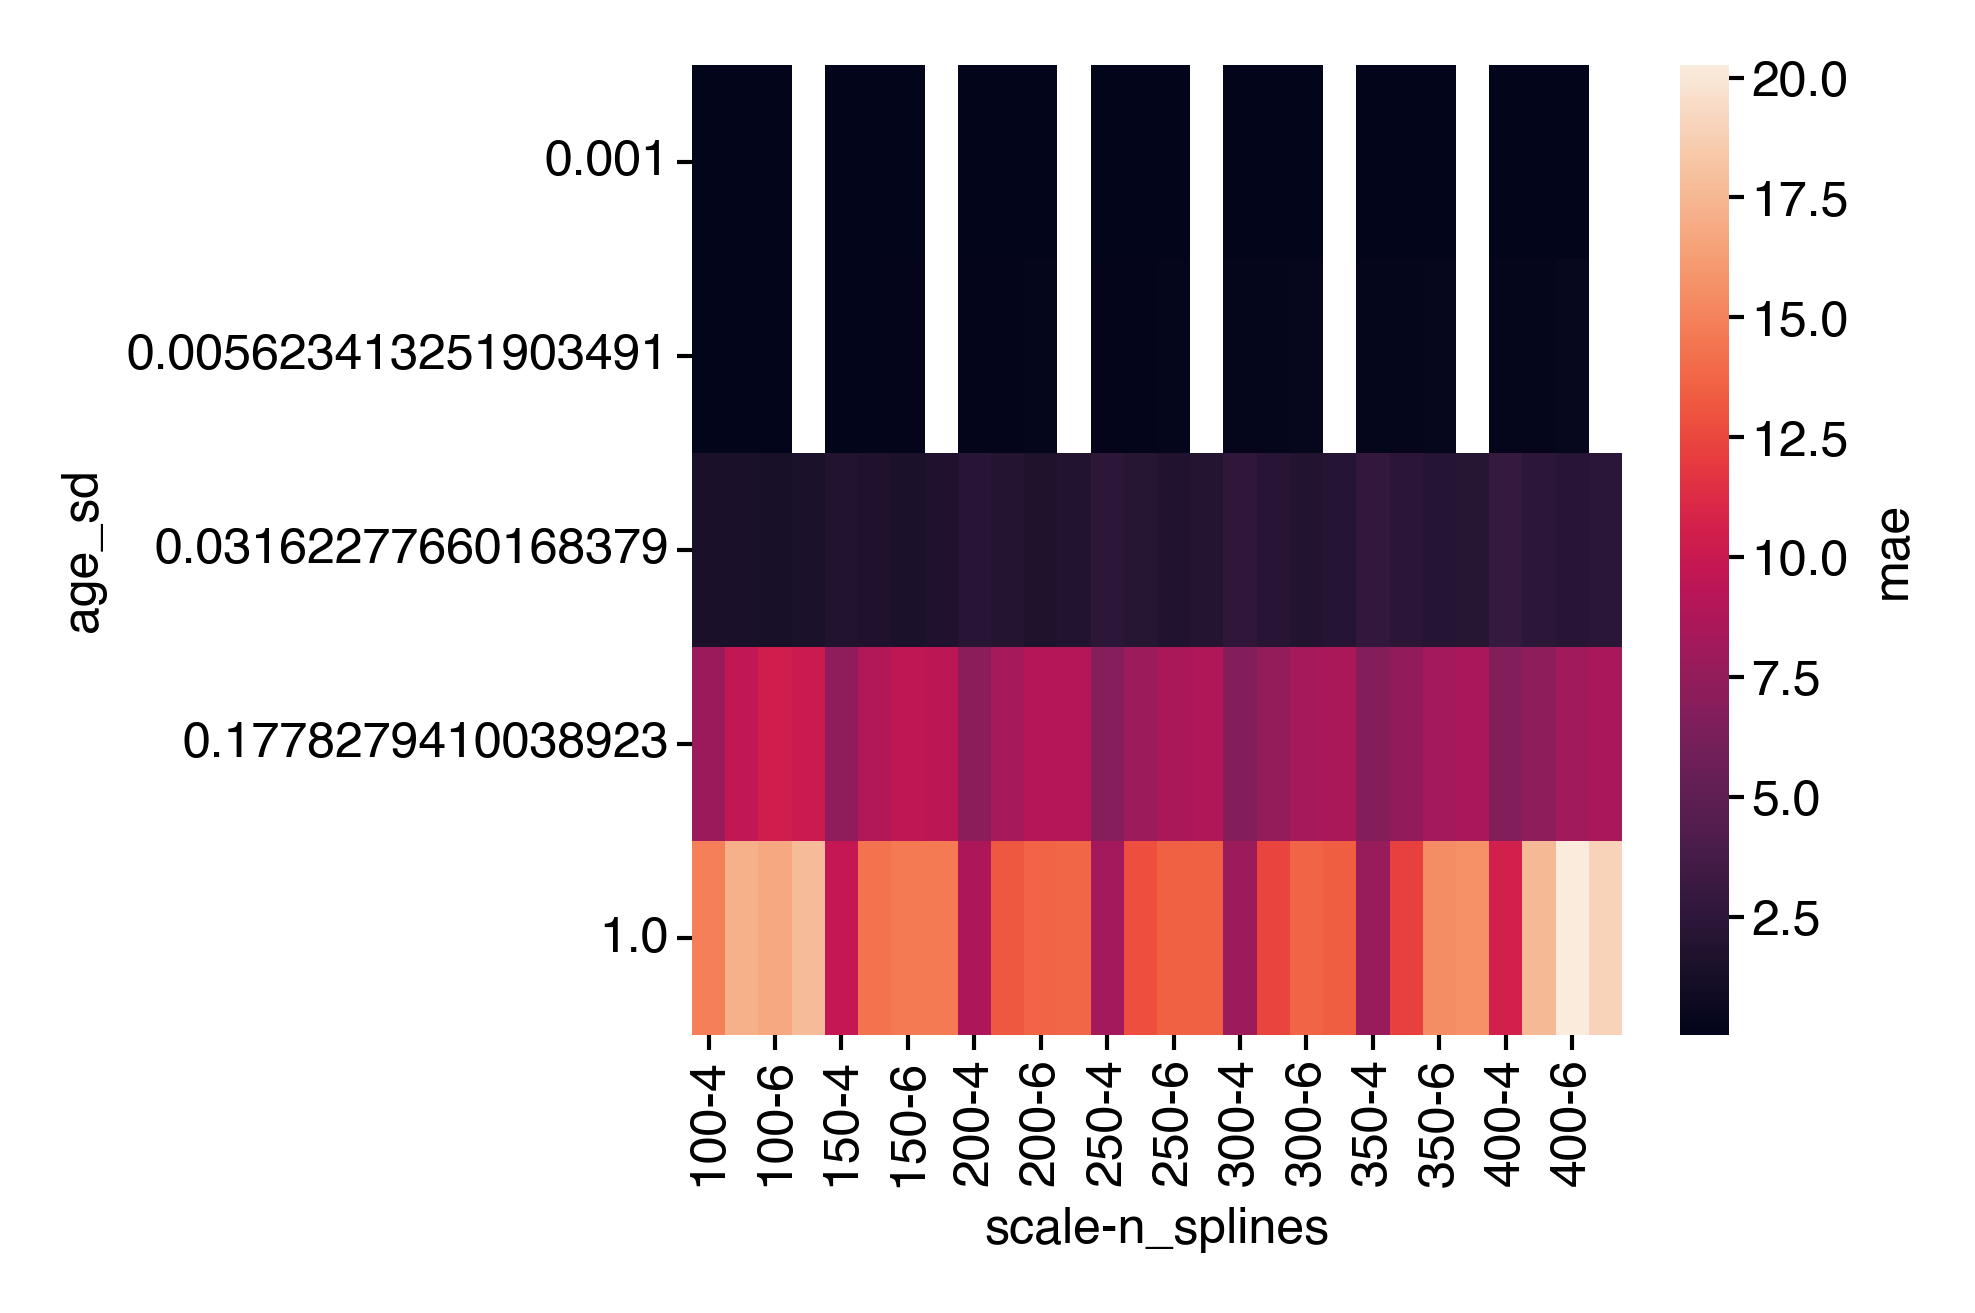

In [25]:
for v in value:
    x = tmp_out.pivot_table(index='age_sd', columns=['scale', 'n_splines'], values=v)
    fig = figure(2.5, 2.1)
    sns.heatmap(x, cbar_kws=dict(label=v))

## More parameters to scan over

In [14]:
outs = []
predictions = []

grid = list(
    product(
        np.logspace(-2, np.log10(0.3), 8),
        range(4, 7),
        np.arange(200, 401, 100),
        range(4, 7),
        range(4, 7),
    )
)

random.shuffle(grid)

for age_sd, n_splines, scale, nds, nss in tqdm(grid):
    hypparams["age_sd"] = float(age_sd)
    hypparams["n_splines"] = int(n_splines)
    hypparams["scale"] = float(scale)
    hypparams["n_development_splines"] = int(nds)
    hypparams["n_sex_splines"] = int(nss)

    try:
        tmp = masked_xval(features, hypparams, 6, n_repeats=3, disable_tqdm=True)
        for k, v in tmp.items():
            v["log_bio_ages"] = v["init_components"].age_normalizer(v["bio_ages"])
        tmp = valmap(keeper, tmp)
        for k, v in tmp.items():
            outs.append(
                {
                    "repeat": k,
                    "age_sd": age_sd,
                    "n_splines": n_splines,
                    "scale": scale,
                    "n_development_splines": nds,
                    "n_sex_splines": nss,
                    "total_resid": np.abs(v["true_ages"] - v["bio_ages"]).mean(),
                    **v,
                }
            )
            tmp_df = pd.DataFrame(
                dict(
                    bio=v["bio_ages"],
                    log_bio=v["log_bio_ages"],
                    chron=v["true_ages"],
                    repeat=k,
                    age_sd=age_sd,
                    n_splines=n_splines,
                    n_development_splines=nds,
                    n_sex_splines=nss,
                    scale=scale,
                )
            )
            tmp_df["mouse_id"] = df.index.get_level_values("mouse")
            tmp_df["bin"] = df.index.get_level_values("bin")

            predictions.append(tmp_df)
    except ValueError:
        print(f"Error {age_sd:0.2f}; {n_splines}")
        pass
    pd.concat(predictions).to_parquet(
        # "/n/scratch/users/w/wg41/2024-06-06-longv2-bambi-param-scan.parquet"
        "/n/scratch/users/w/wg41/2024-06-07-longv2-bambi-param-scan.parquet"
    )

outs_df = pd.DataFrame(outs)
predictions = pd.concat(predictions)

  0%|          | 0/648 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
tmp[0]

{'heldout_ll': -1985596,
 'bio_ages': array([ 2.393193 ,  3.6909645,  3.8593085, ..., 29.08554  , 43.4514   ,
        47.80906  ], dtype=float32),
 'true_ages': array([ 3.4857147,  4.464285 ,  4.9999995, ..., 47.721428 , 48.85714  ,
        49.2857   ], dtype=float32),
 'heldout_r2_total_v3': 0.6403313825574768,
 'log_bio_ages': Array([0.16288383, 0.25367156, 0.26301736, ..., 0.6862483 , 0.7703604 ,
        0.79038715], dtype=float32)}

In [14]:
ac_time = np.arange(-20, 21)
tmp_out = []
for (age_sd, n_splines, scale, nds, nss, r), p in tqdm(
    predictions.groupby(
        [
            "age_sd",
            "n_splines",
            "scale",
            "n_development_splines",
            "n_sex_splines",
            "repeat",
        ]
    )
):
    monotonicity = (
        (
            p.groupby("chron")["bio"]
            .std()
            .rolling(3, center=True, min_periods=1)
            .mean()
            .diff(2)
            / 2
        )
        > 0
    ).mean()
    median_bio_mae = (
        p.groupby("chron")["bio"]
        .median()
        .reset_index()
        .diff(axis=1)
        .drop(columns=["chron"])
        .abs()
        .mean()["bio"]
    )

    # compute difference in rank
    bio_age_df = p.pivot_table(index="bin", columns="mouse_id", values="bio")
    mtx = bio_age_df.interpolate().rank(axis=1)
    # mtx = bio_age_df.apply(fill_median, axis=1).rank(axis=1)
    avg_rank_diff = (mtx.diff(periods=3) / 3).abs().mean().mean()
    ac_dict = {}
    for m in mtx.columns:
        ac_dict[m] = [mtx[m].autocorr(x) for x in ac_time]
    ac_df = pd.DataFrame(ac_dict, index=ac_time)
    taus = ac_df.apply(estimate_tau).rename("tau")
    age_flicker = (p.groupby("mouse_id")["bio"].diff(periods=2) / 2).abs().mean()

    tmp_out.append(
        dict(
            mono=monotonicity,
            mae=median_bio_mae,
            ac_tau=taus.mean(),
            med_ac_tau=taus.median(),
            repeat=r,
            age_sd=age_sd,
            n_splines=n_splines,
            scale=scale,
            rank_diff=avg_rank_diff,
            age_flicker=age_flicker,
            nss=nss,
            nds=nds,
        )
    )
tmp_out = pd.DataFrame(tmp_out)

  0%|          | 0/1944 [00:00<?, ?it/s]

In [16]:
tmp_out.to_parquet(
    "/n/scratch/users/w/wg41/2024-06-06-processed-longv2-bambi-param-scan.parquet"
)


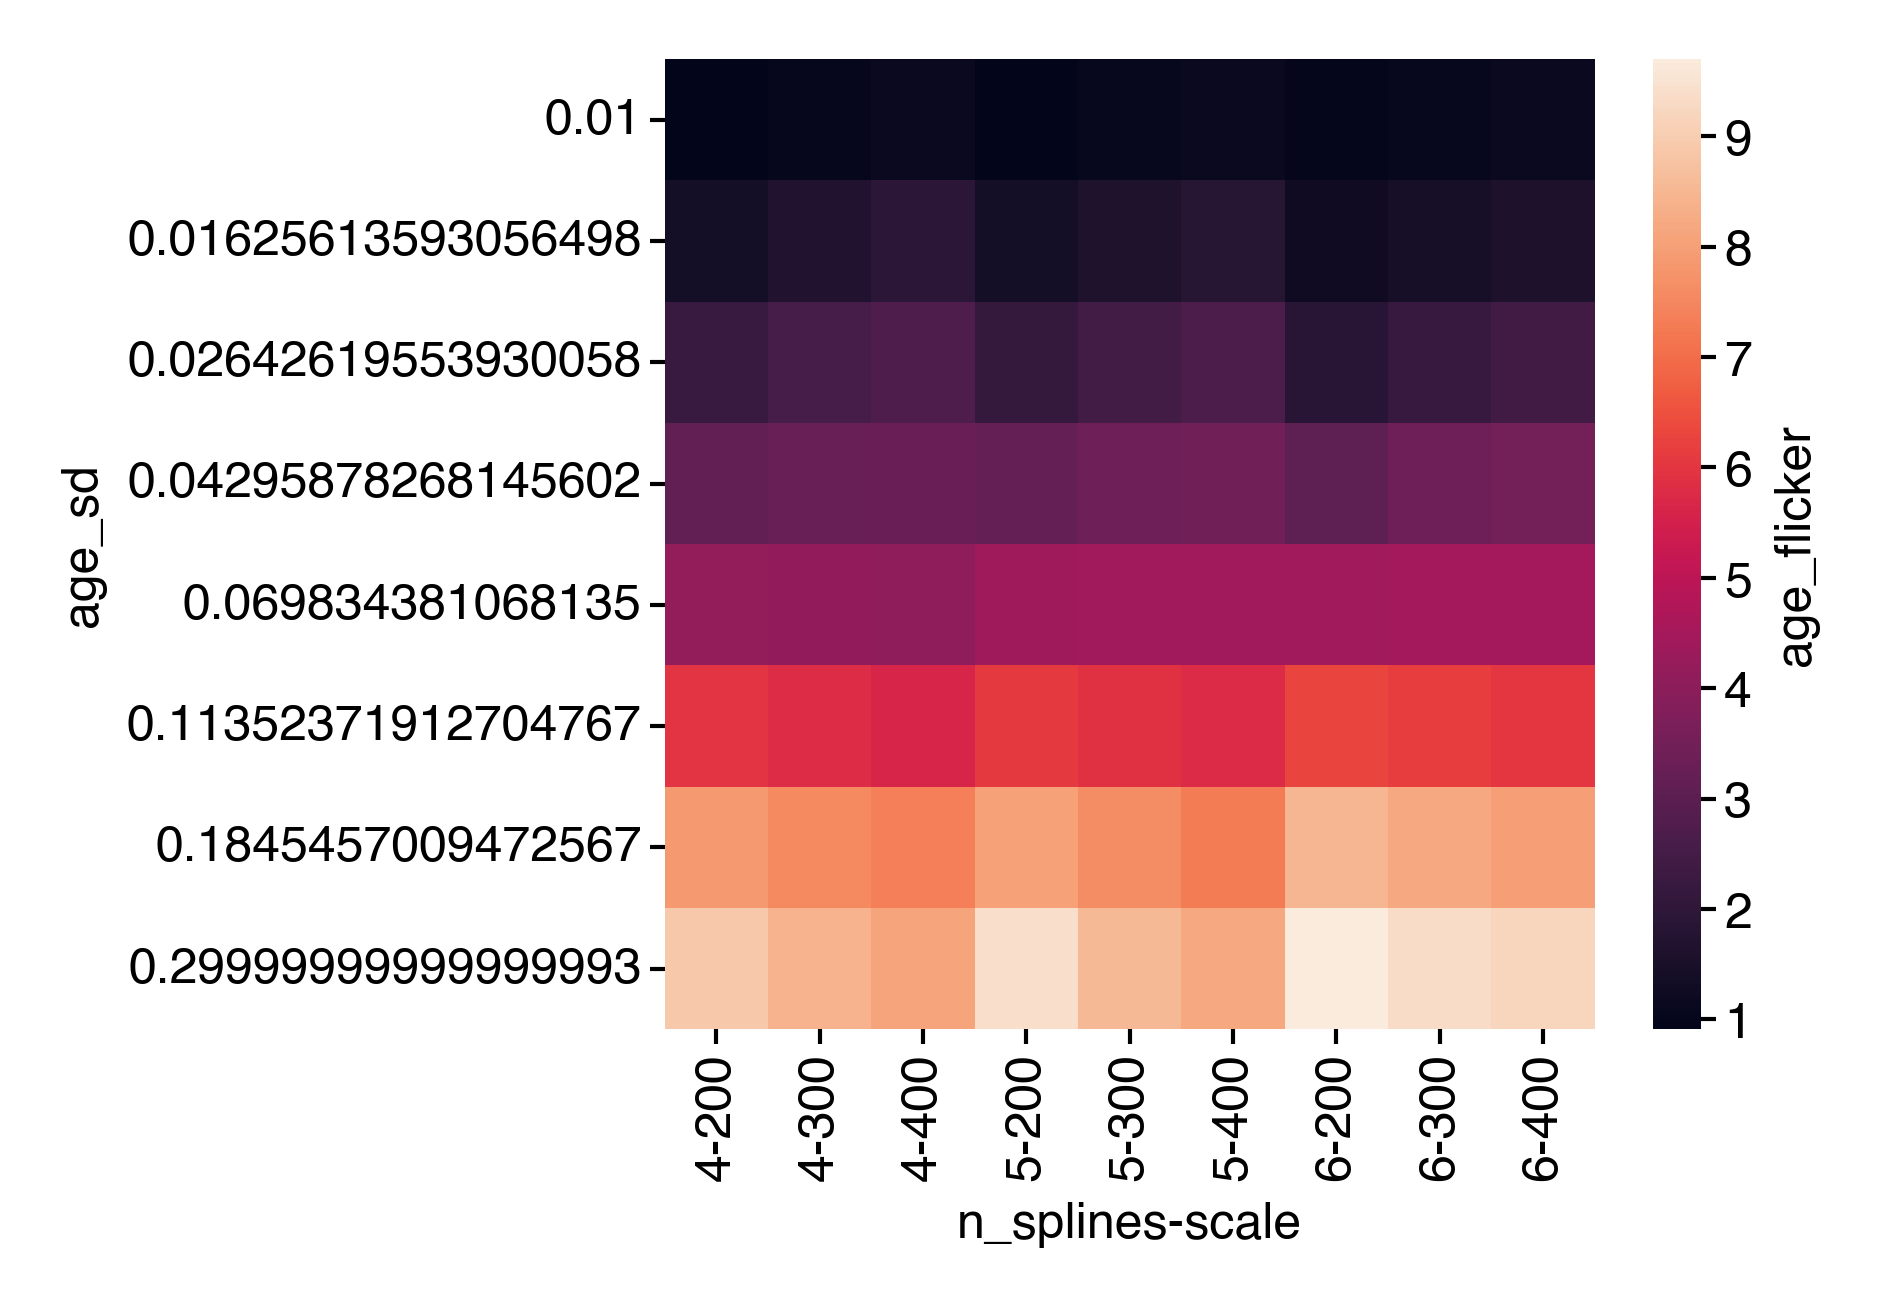

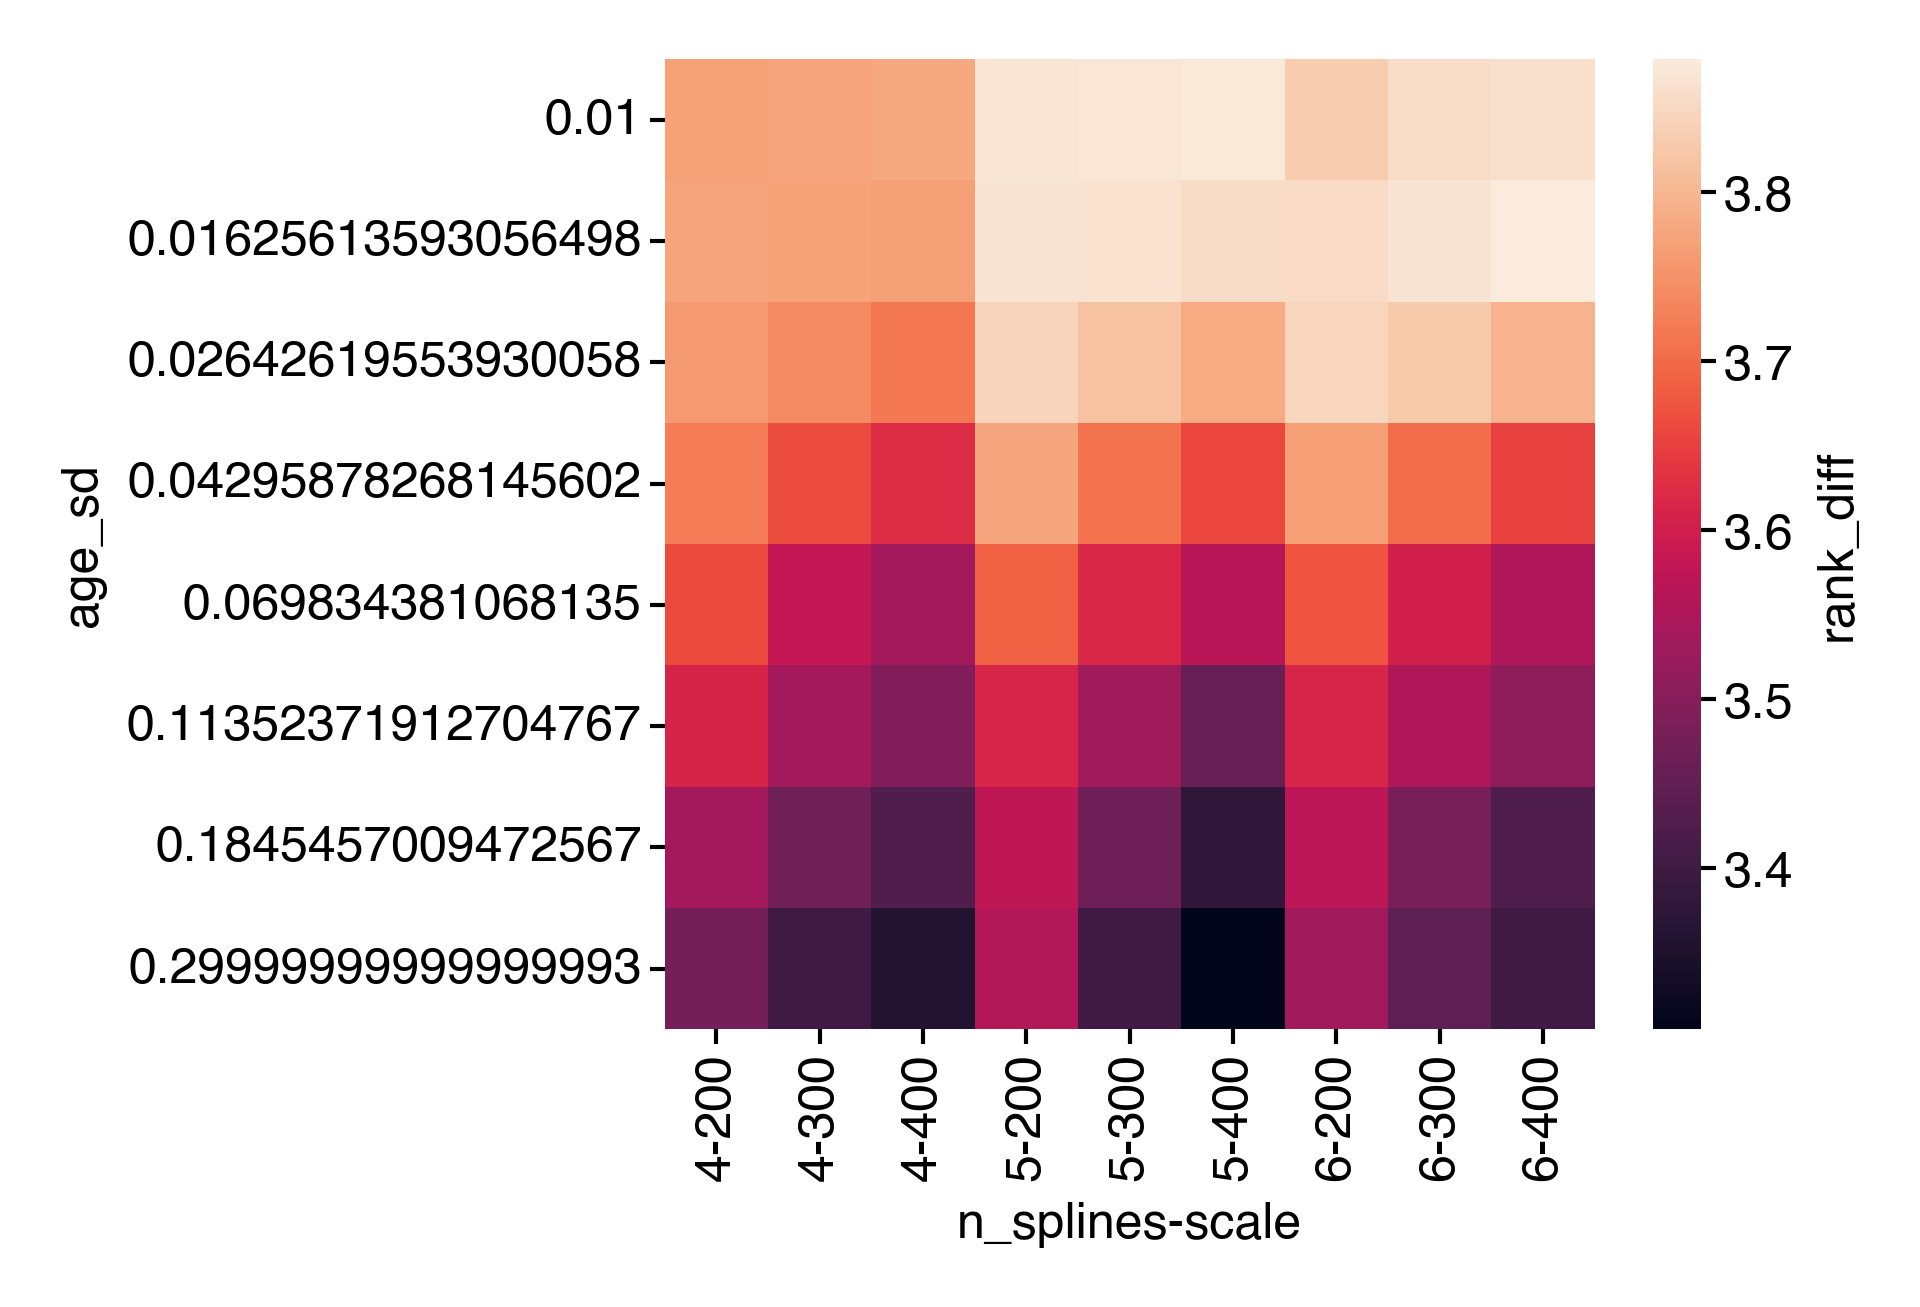

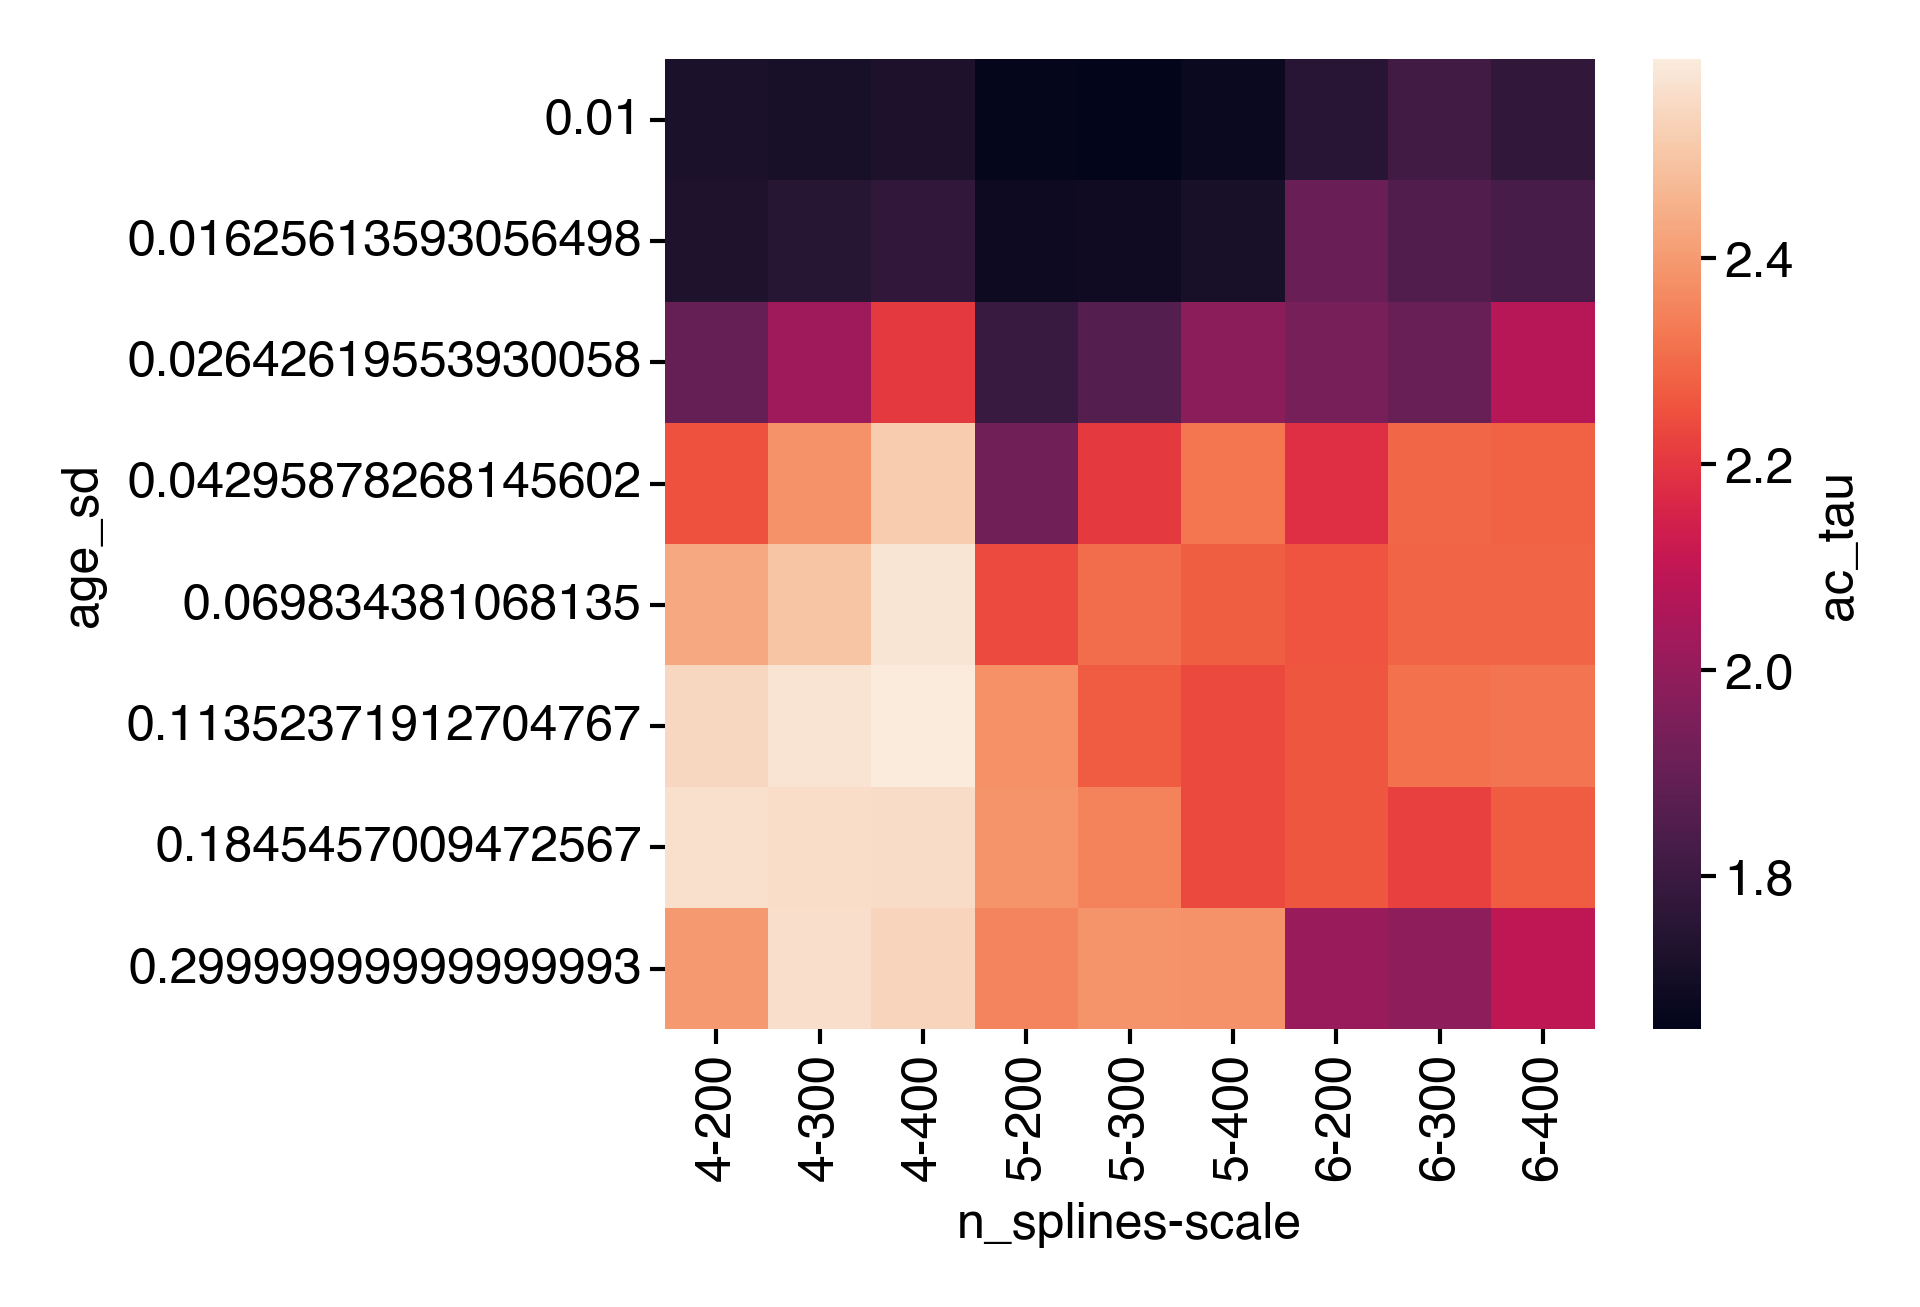

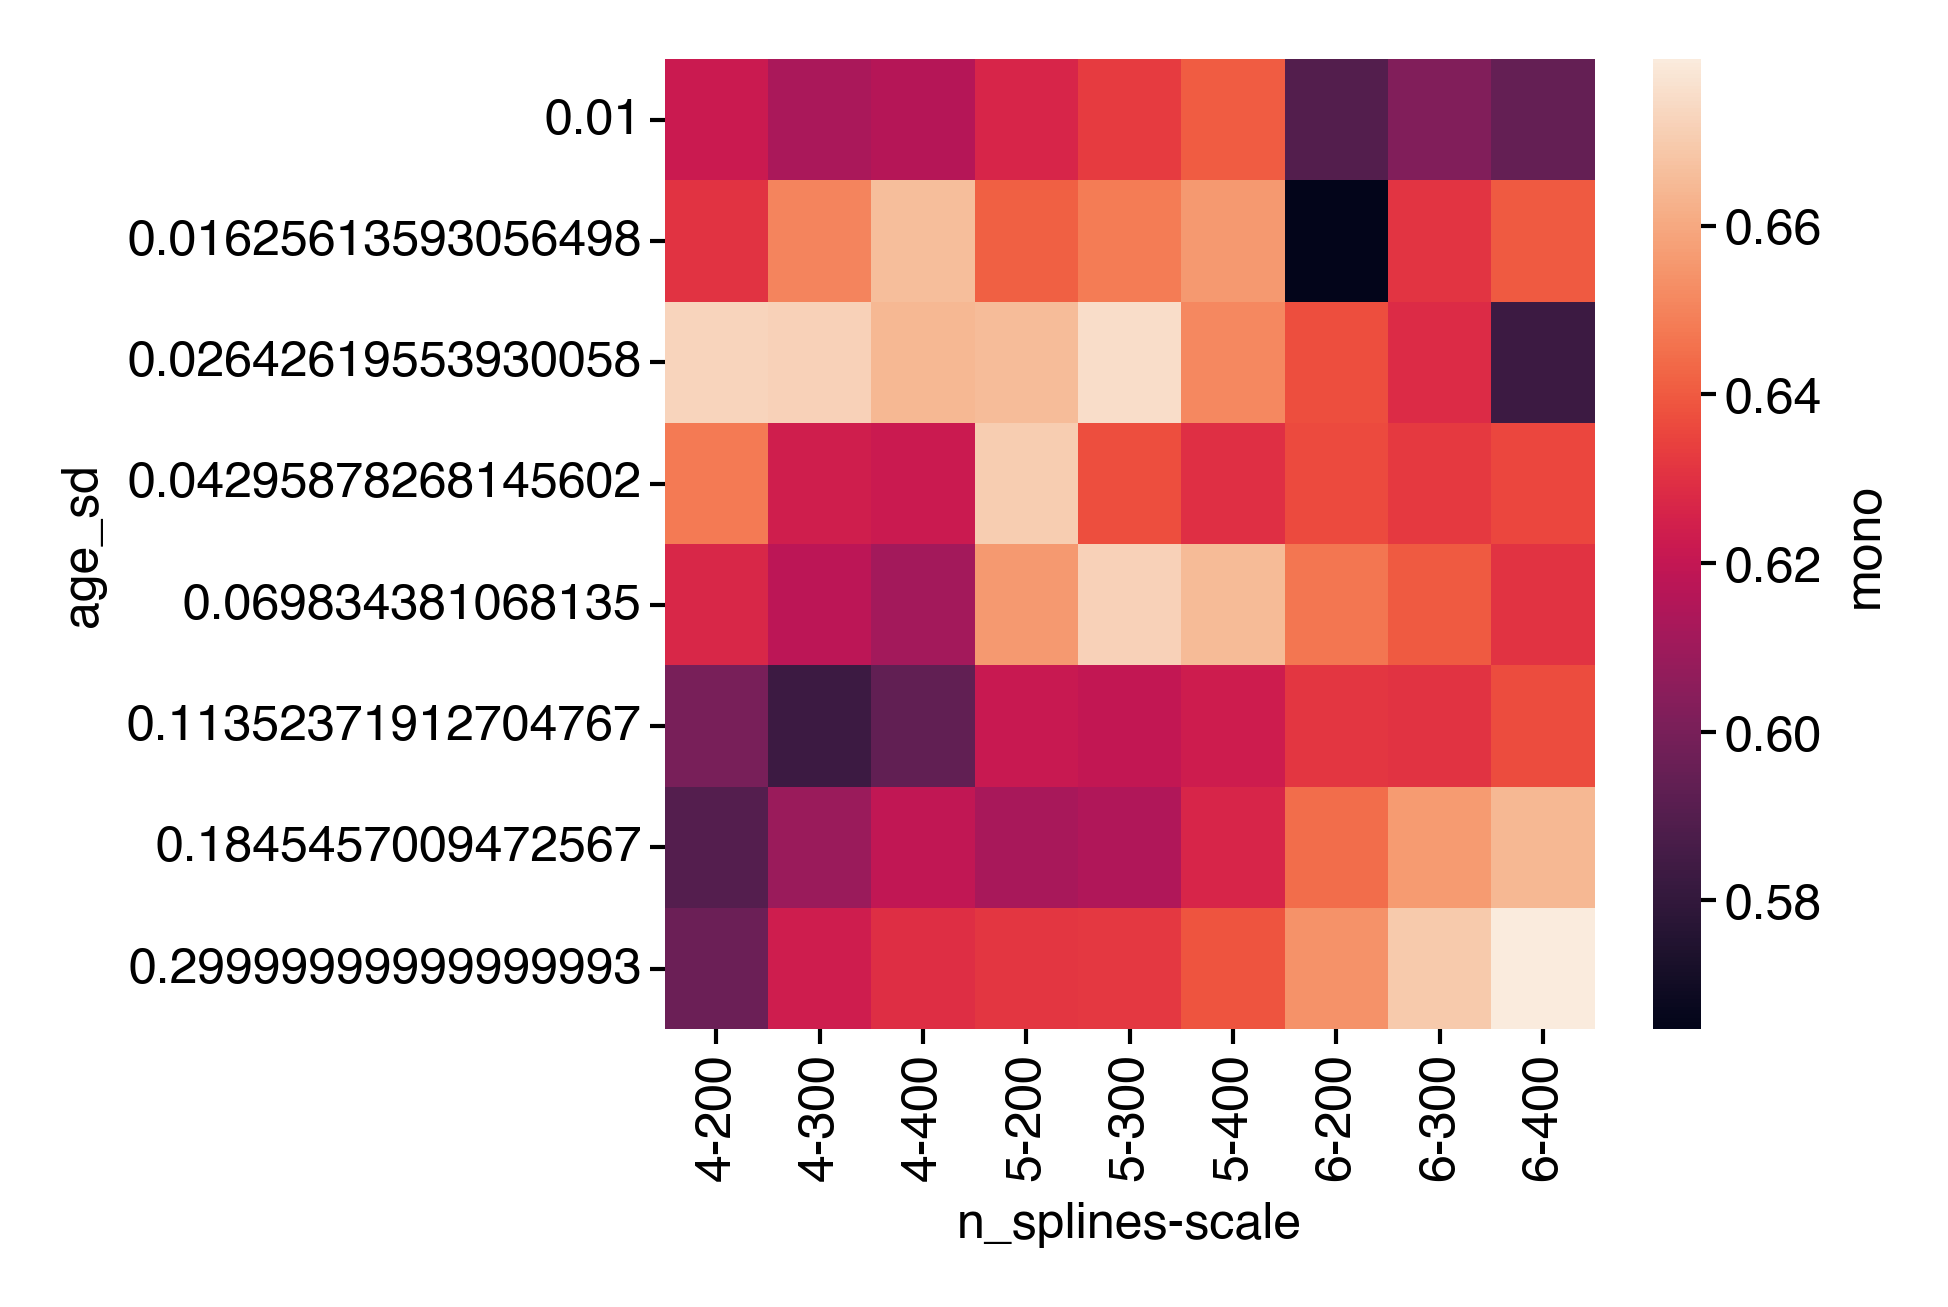

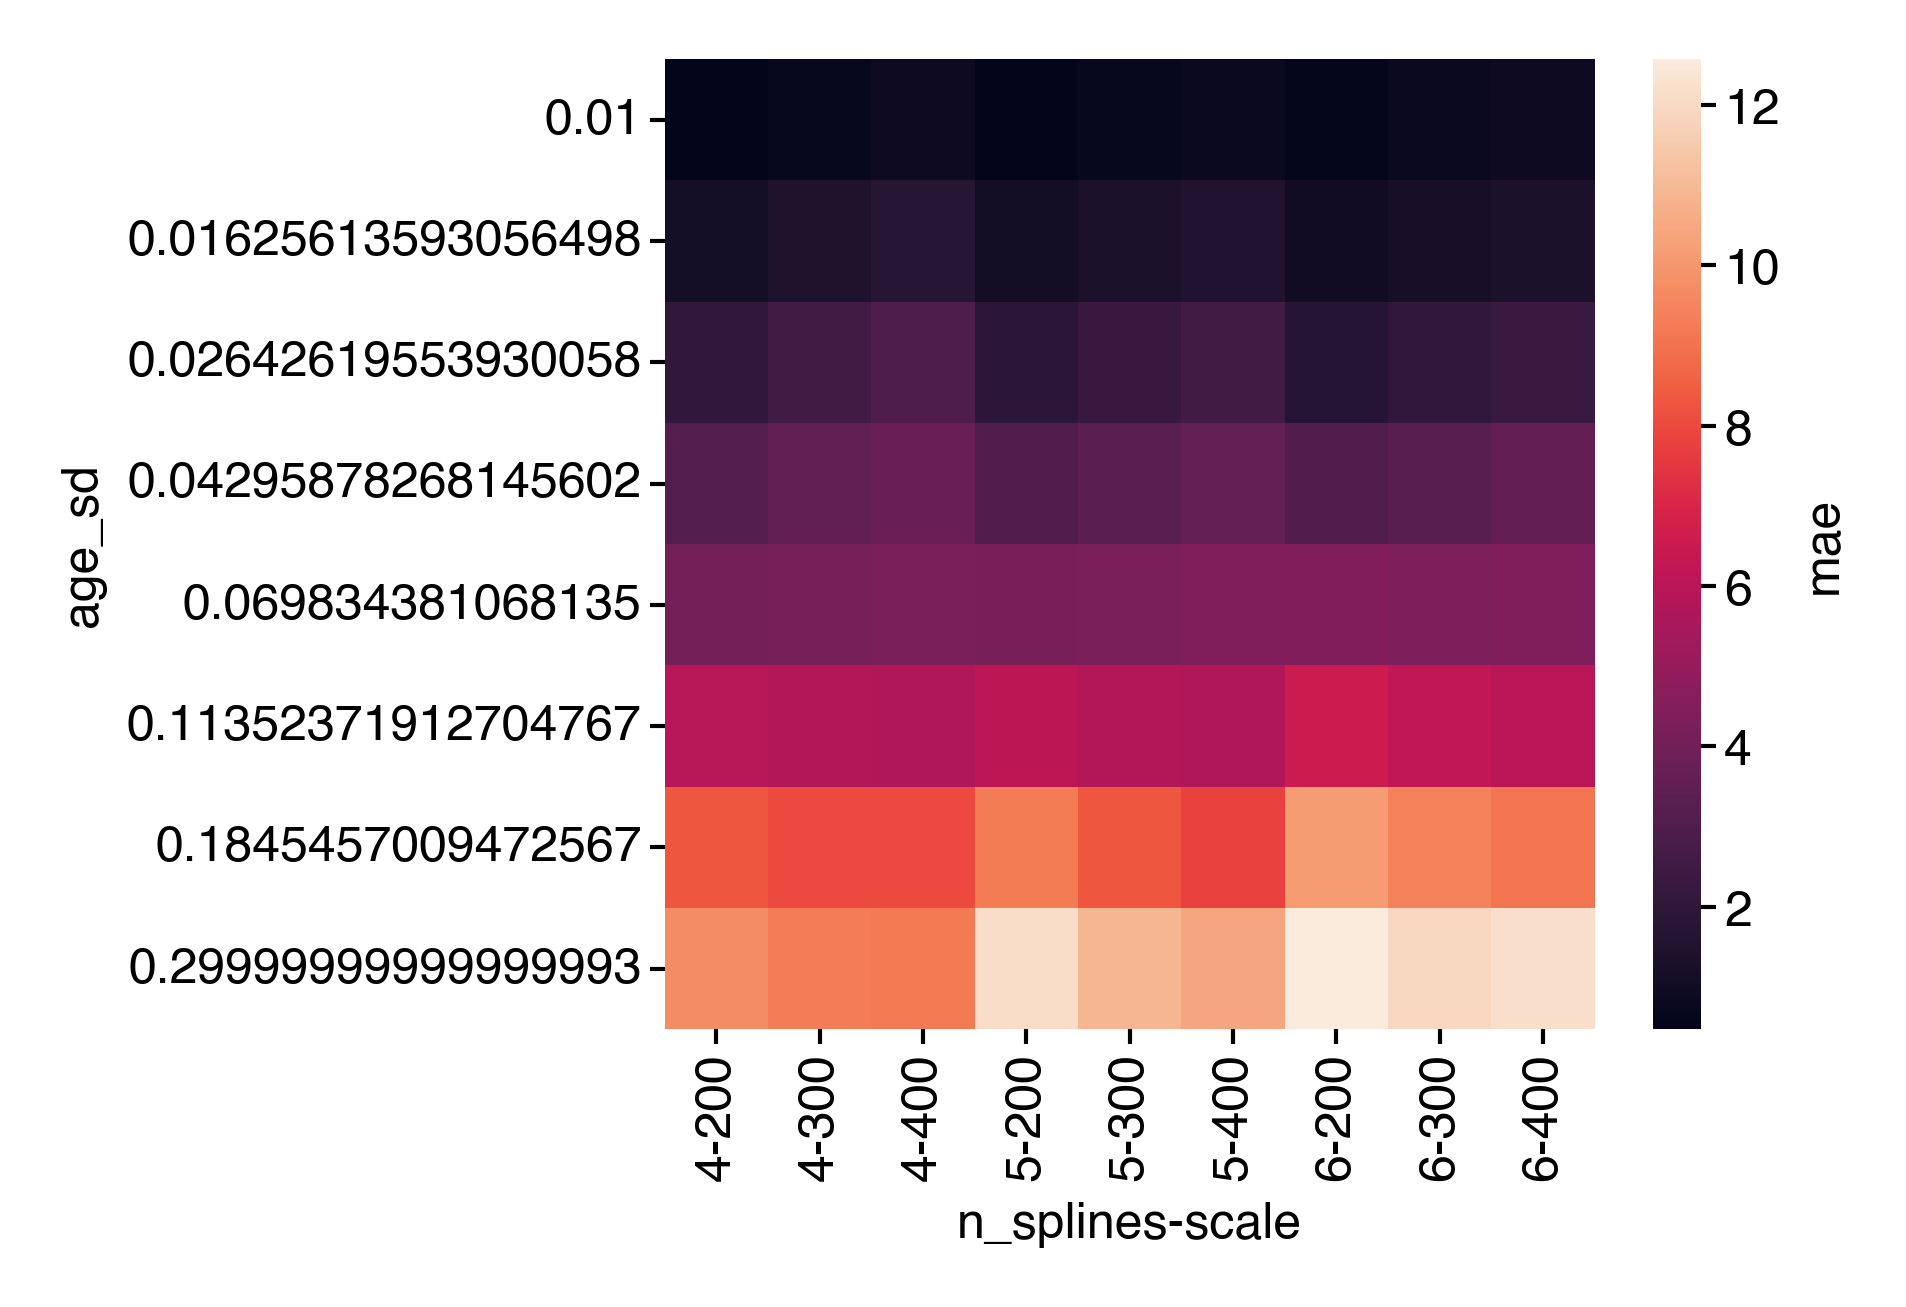

In [15]:
for v in value:
    x = tmp_out.pivot_table(index='age_sd', columns=['n_splines', 'scale'], values=v)
    fig = figure(2.5, 2.1)
    sns.heatmap(x, cbar_kws=dict(label=v))